Atenção: para execuções com foco nos resultados do XAIIRT basta executar:
- "Install dependences";
- "Util";
- "Preprocess";
- "Analysis;" e
- "XAI+IRT".:



Generate files?


In [4]:
do_download = True #when change to True, run all notebook!

## Install dependences

Set of libraries and software packages needed to run all program steps.

Note, specific versions are required in some cases!

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# XAI Tools
!pip install --upgrade scikit-learn==0.20.3
!pip install lofo-importance
!pip install git+https://github.com/oracle/Skater.git #online usa-se este
#!pip install -U skater==1.1.2 -q #local usa-se este

!pip install info_gain
!pip install shap
!pip install eli5
!pip install dalex
!pip install py-ciu
!pip install plotly
!pip install adjustText
!pip install scikit_posthocs
!pip install openml
!pip install prince

import eli5
import shap
import dalex as dx
import numpy as np
import pandas as pd
import openml
import pickle
import matplotlib.pyplot as plt
import statistics
import os
import gc
import math
import matplotlib.cm as cm
import prince
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp
import copy


from ciu import determine_ciu
from lofo import LOFOImportance, FLOFOImportance, Dataset
from info_gain import info_gain
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import friedmanchisquare
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_samples, silhouette_score
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import preprocessing

#IRT
!wget https://raw.githubusercontent.com/LucasFerraroCardoso/IRT_OpenML/master/decodIRT_OtML.py
!wget https://raw.githubusercontent.com/LucasFerraroCardoso/IRT_OpenML/master/decodIRT_MLtIRT.py
!wget https://raw.githubusercontent.com/LucasFerraroCardoso/IRT_OpenML/master/decodIRT_analysis.py
!wget https://raw.githubusercontent.com/LucasFerraroCardoso/IRT_OpenML/master/decodIRT_create_benchmark.py

!pip install openml
!pip install rpy2
!pip install catsim

from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
import random

from re import A
from scipy.special import expit
from numpy import percentile, concatenate, array, linspace, append

     |████████████████████████████████| 5.4 MB 23.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.3 which is incompatible.
  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-q88qo6ws
  Running command git clone -q https://github.com/oracle/Skater.git /tmp/pip-req-build-q88qo6ws
     |████████████████████████████████| 275 kB 20.0 MB/s 
  Created wheel for skater: filename=skater-1.1.2b1-py3-none-any.whl size=4637019 sha256=1739b20ce210be8189fda81812c13ad6f1dd10d6d4c9f87ffc3690bc34ec

## Util

In [5]:
class Util():
  def is_int(n):
    isInteger = False
    for i in range(len(n)):
      if isinstance(n[i],float):
        return False
    return True

  
  
  def powerSetLimited(s,l):

    def powerset(s):
      x = len(s)
      masks = [1 << i for i in range(x)]
      for i in range(1 << x):
          yield [ss for mask, ss in zip(masks, s) if i & mask]
    
    psl = []
    ps = list(powerset(s))
    for _,i in enumerate(ps):
      if len(i) <= l and len(i)>0:
        psl.append(i)
    return psl
  
  def auc_score(y, y_pred):
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=2)
    
    return metrics.auc(fpr, tpr)


## XAI tools (Ciu,Dalex, Eli5, Lofo, Shap, Skater and eXirt)

In [6]:
############## GENERAL CONTROL #######################
proposal_1_pool = 1
proposal_2_loop = 2
exec_proposal = proposal_2_loop

# verbose
verbose = False
verbose_graph = False

download_files = False

# performance
exec_accuracy = 1
exec_auc = 2
exec_performance = exec_accuracy
normalize_performance = True

####### IRT ################
#execute theta ou trueScore
exec_theta = 0
exec_trueScore = 1
exec_base_irt_score = exec_trueScore

# calculo de  theta
theta_sum = 0
theta_min = 1
theta_mean = 2
exec_calc_theta = theta_mean


# irt algorithm ‘ternary’, ‘dichotomous’, ‘fibonacci’, ‘golden’, ‘brent’, ‘bounded’ and ‘golden2’
irt_method_fibonacci = '-metodo fibonacci'
irt_method_bounded = '-metodo bounded'
irt_method_ternary = '-metodo ternary' #long time execution
irt_method_dichotomous = '-metodo dichotomous' #long time execution
irt_method_golden = '-metodo golden'
irt_method_brent = '-metodo brent'
irt_method_golden2 = '-metodo golden2' #problem in execution
irt_method = irt_method_bounded

# controle de propriedades do IRT
irt_discriminate = True #False remove the property by IRTs calc.
irt_difficulty = True #False remove the property by IRTs calc.
irt_divine = True #False remove the property by IRTs calc.

############## PROPOSAL 1 POOL #######################
include_original_clf_data_pool = True
number_of_features_deletion = 2 # values 1 to ++

list_clf_pool = [] #empity

############## PROPOSAL 2 LOOP #######################

include_original_clf_data_loop = True
number_of_features_variation = 2 # values 1 to 4

# test or train
exec_test = 0
exec_train = 1
exec_in = exec_test

#loop of models variation
exec_permutation = 0 # random base
exec_noise = 1 # random base
exec_zeros = 2
exec_norm = 3 
exec_ordup = 4
exec_orddown = 5
exec_inver = 6
exec_binning = 7
exec_mult_neg = 8
exec_mean = 9
exec_std = 10
exec_zscore = 11
exec_variation_method = [exec_mult_neg, exec_binning]

#list of thetas
list_clf_loop = [] #empity

########## global declaration #############

# model = None
# X_train = None
# X_test = None
# y_test = None
# y_train = None

def run_prepare(model,data_exec_x, data_exec_y, X_train, X_test, y_train, y_test):
  %%rm '/content/tabela_base_para_executar_irt.csv'
  %%rm '/content/tabela_base_para_executar_irt_accuracy.csv'


  #prediction
  original_outputs = model.predict(data_exec_x)


  #XAI-IRT
  # train, test, model and outputs

  #Loop of models
  df_loop_of_models = pd.DataFrame()
  df_loop_of_models_performance = pd.DataFrame(columns=['Metodo','Acuracia'])



  if exec_proposal == proposal_2_loop:
    if verbose:
      print('Original data')
      print(data_exec_x)

    number_of_instances = len(data_exec_x)

    if include_original_clf_data_loop:
      str_tmp = 'Clf original data'
      if exec_performance == exec_accuracy:
        result_accuracy = accuracy_score(y_true = original_outputs, y_pred = original_outputs, normalize=normalize_performance) #accuracy
      else:
        if exec_performance == exec_auc:
          result_accuracy = Util.auc_score(original_outputs, original_outputs) #AUC

      result_pred = (original_outputs == data_exec_y.values) #binarization
      df_loop_of_models[str_tmp] = result_pred.astype(int)[:] #boolean to int
      df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_tmp,'Acuracia':result_accuracy},ignore_index=True)

    
    #inset variation of ONE attribute in loop of models
    if number_of_features_variation >= 1:
      for _, variation in enumerate(exec_variation_method):
        for id,c in enumerate(data_exec_x.columns):
          #criando cópia do dado inicial
          data_exec_x_copy = data_exec_x.copy()
          if variation == exec_permutation:
            #trocando posições de cada instância do atributo da vez
            random_id = random.sample(range(0,number_of_instances), number_of_instances)
            data_exec_x_copy[c] = data_exec_x_copy[c].values[random_id]
            method = 'Permutation'
          else:
            if variation == exec_noise:
              #aplica ruido a cada instâcia do atributo da vez
              noise = np.random.normal(0, 1, number_of_instances)
              data_exec_x_copy[c] = data_exec_x_copy[c] + noise
              method = 'Noise'
            else: 
              if variation == exec_zeros:
                #aplica zeros a cada instância do atributo da vez
                zeros = np.zeros(number_of_instances)
                data_exec_x_copy[c] = zeros
                method = 'Zeros'
              else:
                if variation == exec_norm:
                  #normaliza os elementos
                  norm = np.linalg.norm(data_exec_x_copy[c])
                  normal_array = data_exec_x_copy[c]/norm
                  data_exec_x_copy[c] = normal_array
                  method = 'Normalization'
                else:
                  if variation == exec_ordup:
                    #ordena em ordem crescente os elementos
                    order_up = np.sort(data_exec_x_copy[c])
                    data_exec_x_copy[c] = order_up
                    method = 'Ordernation_Up'
                  else:
                    if variation == exec_orddown:
                      #ordena em ordem decrescente os elementos
                      order_down = -np.sort(-data_exec_x_copy[c])
                      data_exec_x_copy[c] = order_down
                      method = 'Ordernation_Down'
                    else:
                      if variation == exec_inver:
                        #inverte os elementos
                        transp = np.flipud(data_exec_x_copy[c])
                        data_exec_x_copy[c] = transp
                        method = 'Invertion'
                      else:
                        if variation == exec_binning:
                          #inverte os elementos
                          mean_arr = np.mean(data_exec_x_copy[c])
                          binn = np.digitize(data_exec_x_copy[c],bins=[mean_arr])
                          data_exec_x_copy[c] = binn
                          method = 'Binning'
                        else:
                          if variation == exec_mult_neg:
                            #multiplica por -1
                            data_exec_x_copy[c] = data_exec_x_copy[c] * -1
                            method = 'MultNeg'
                          else:
                            if variation == exec_mean:
                              #mean
                              inst =  len(data_exec_x_copy[c])
                              data_exec_x_copy[c] = [statistics.mean(data_exec_x_copy[c])]*inst
                              method = 'Mean'
                            else:
                              if variation == exec_std:
                                #std
                                inst =  len(data_exec_x_copy[c])
                                data_exec_x_copy[c] = [statistics.stdev(data_exec_x_copy[c])]*inst
                                method = 'Std'
                              else:
                                if variation == exec_zscore:
                                  #zscore
                                  data_exec_x_copy[c] = PreprocessDefault.z_score_serie(data_exec_x_copy[c])
                                  method = 'Zscore'

          if verbose:
            print('')
            print(method,' of ',c)
            print(data_exec_x_copy)
          if verbose_graph:
            data_exec_x_copy.plot.kde(by=data_exec_x_copy.columns, alpha=0.5,title=str(method+' of '+c))

          result_pred = model.predict(data_exec_x_copy) #prediction

          if exec_performance == exec_accuracy:
            result_accuracy = accuracy_score(y_true = original_outputs, y_pred = result_pred, normalize=normalize_performance) #accuracy
          else:
            if exec_performance == exec_auc:
              result_accuracy = Util.auc_score(original_outputs, result_pred) #AUC

          result_pred = (result_pred == original_outputs) #binarization
          str_model_name = 'Clf '+method+' "'+str(c)+'"'
          list_clf_loop.append(str_model_name)
          df_loop_of_models[str_model_name] = result_pred.astype(int)[:]
          df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_model_name,'Acuracia':result_accuracy},ignore_index=True,verify_integrity=True)
          #frame = pd.DataFrame(data={'Metodo':str_model_name,'Acuracia':result_accuracy},index = [0])
          #df_loop_of_models_performance = pd.concat([df_loop_of_models_performance,frame],ignore_index=True, axis = 0)


    #inset invertion of TWO attributes in loop of models
    if number_of_features_variation >= 2:
      for _,variation in enumerate(exec_variation_method):
        for id1,c1 in enumerate(data_exec_x.columns):
          for id2,c2 in enumerate(data_exec_x.columns):
            if id2 > id1:
              #criando cópia do dado inicial
              data_exec_x_copy = data_exec_x.copy()
              if variation == exec_permutation:
                #trocando posições de cada instância do atributo da vez
                random_id = random.sample(range(0,number_of_instances), number_of_instances)
                data_exec_x_copy[c1] = data_exec_x_copy[c1].values[random_id]
                random_id = random.sample(range(0,number_of_instances), number_of_instances)
                data_exec_x_copy[c2] = data_exec_x_copy[c2].values[random_id]
                method = 'Permutation'
              else:
                if variation == exec_noise:
                  #aplica ruido a cada instâcia do atributo da vez
                  noise = np.random.normal(0, 1, number_of_instances)
                  data_exec_x_copy[c1] = data_exec_x_copy[c1] + noise
                  noise = np.random.normal(0, 1, number_of_instances)
                  data_exec_x_copy[c2] = data_exec_x_copy[c2] + noise
                  method = 'Noise'
                else:
                  if variation == exec_zeros:
                    #aplica zeros a cada instância do atributo da vez
                    zeros = np.zeros(number_of_instances)
                    data_exec_x_copy[c1] = zeros
                    data_exec_x_copy[c2] = zeros
                    method = 'Zeros'
                  else:
                    if variation == exec_norm:
                      #normaliza os elementos
                      norm = np.linalg.norm(data_exec_x_copy[c1])
                      normal_array = data_exec_x_copy[c1]/norm
                      data_exec_x_copy[c1] = normal_array
                      norm = np.linalg.norm(data_exec_x_copy[c2])
                      normal_array = data_exec_x_copy[c2]/norm
                      data_exec_x_copy[c2] = normal_array
                      method = 'Normalization'
                    else:
                      if variation == exec_ordup:
                        #ordena em ordem crescente os elementos
                        order_up = np.sort(data_exec_x_copy[c1])
                        data_exec_x_copy[c1] = order_up
                        order_up = np.sort(data_exec_x_copy[c2])
                        data_exec_x_copy[c2] = order_up
                        method = 'Ordernation_Up'
                      else:
                        if variation == exec_orddown:
                          #ordena em ordem decrescente os elementos
                          order_down = -np.sort(-data_exec_x_copy[c1])
                          data_exec_x_copy[c1] = order_down
                          order_down = -np.sort(-data_exec_x_copy[c2])
                          data_exec_x_copy[c2] = order_down
                          method = 'Ordernation_Down'
                        else:
                          if variation == exec_inver:
                            #inverte os elementos
                            transp = np.flipud(data_exec_x_copy[c1])
                            data_exec_x_copy[c1] = transp
                            transp = np.flipud(data_exec_x_copy[c2])
                            data_exec_x_copy[c2] = transp
                            method = 'Invertion'
                          else:
                            if variation == exec_binning:
                              #inverte os elementos
                              mean_arr = np.mean(data_exec_x_copy[c1])
                              binn = np.digitize(data_exec_x_copy[c1],bins=[mean_arr])
                              data_exec_x_copy[c1] = binn
                              mean_arr = np.mean(data_exec_x_copy[c2])
                              binn = np.digitize(data_exec_x_copy[c2],bins=[mean_arr])
                              data_exec_x_copy[c2] = binn
                              method = 'Binning'
                            else:
                              if variation == exec_mult_neg:
                                #multiplica por -1
                                data_exec_x_copy[c1] = data_exec_x_copy[c1] * -1
                                data_exec_x_copy[c2] = data_exec_x_copy[c2] * -1
                                method = 'MultNeg'
                              else:
                                if variation == exec_mean:
                                  #mean
                                  inst =  len(data_exec_x_copy[c1])
                                  data_exec_x_copy[c1] = [statistics.mean(data_exec_x_copy[c1])]*inst
                                  data_exec_x_copy[c2] = [statistics.mean(data_exec_x_copy[c2])]*inst
                                  method = 'Mean'
                                else:
                                  if variation == exec_std:
                                    #std
                                    inst =  len(data_exec_x_copy[c1])
                                    data_exec_x_copy[c1] = [statistics.stdev(data_exec_x_copy[c1])]*inst
                                    data_exec_x_copy[c2] = [statistics.stdev(data_exec_x_copy[c2])]*inst
                                    method = 'Std'
                                  else:
                                    if variation == exec_zscore:
                                      #zscore
                                      data_exec_x_copy[c1] = PreprocessDefault.z_score_serie(data_exec_x_copy[c1])
                                      data_exec_x_copy[c2] = PreprocessDefault.z_score_serie(data_exec_x_copy[c2])
                                      method = 'Zscore'

              str_model_name = 'Clf '+method+' "'+str(c1)+'" and "'+str(c2)+'"'
              if verbose:
                print('')
                print(str_model_name)
                print(data_exec_x_copy)
              if verbose_graph:
                data_exec_x_copy.plot.kde(by=data_exec_x_copy.columns, alpha=0.5,title=str_model_name)

              #executando o modelo com o atributo da vez embaralhado
              result_pred = model.predict(data_exec_x_copy) #prediction

              if exec_performance == exec_accuracy:
                result_accuracy = accuracy_score(y_true = original_outputs, y_pred = result_pred, normalize=normalize_performance) #accuracy
              else:
                if exec_performance == exec_auc:
                  result_accuracy = Util.auc_score(original_outputs, result_pred) #AUC

              result_pred = (result_pred == original_outputs) #binarization
              str_model_name = 'Clf '+method+' "'+str(c1)+'" and "'+str(c2)+'"'
              list_clf_loop.append(str_model_name)
              df_loop_of_models[str_model_name] = result_pred.astype(int)[:]
              df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_model_name,'Acuracia':result_accuracy},ignore_index=True, verify_integrity=True)
              #frame = pd.DataFrame(data={'Metodo':str_model_name,'Acuracia':result_accuracy},index = [0])
              #df_loop_of_models_performance = pd.concat([df_loop_of_models_performance,frame],ignore_index=True, axis = 0)
            else:
              pass

    #inset invertion of Three attributes in loop of models
    if number_of_features_variation >= 3:
      for _, variation in enumerate(exec_variation_method):
        for id1,c1 in enumerate(data_exec_x.columns):
          for id2,c2 in enumerate(data_exec_x.columns):
            for id3,c3 in enumerate(data_exec_x.columns):
              if id3 > id2 and id2 > id1:
                #criando cópia do dado inicial
                data_exec_x_copy = data_exec_x.copy()
                if variation == exec_permutation:
                  #trocando posições de cada instância do atributo da vez
                  random_id = random.sample(range(0,number_of_instances), number_of_instances)
                  data_exec_x_copy[c1] = data_exec_x_copy[c1].values[random_id]
                  random_id = random.sample(range(0,number_of_instances), number_of_instances)
                  data_exec_x_copy[c2] = data_exec_x_copy[c2].values[random_id]
                  random_id = random.sample(range(0,number_of_instances), number_of_instances)
                  data_exec_x_copy[c3] = data_exec_x_copy[c3].values[random_id]
                  method = 'Permutation'
                else:
                  if variation == exec_noise:
                    #aplica ruido a cada instâcia do atributo da vez
                    noise = np.random.normal(0, 1, number_of_instances)
                    data_exec_x_copy[c1] = data_exec_x_copy[c1] + noise
                    noise = np.random.normal(0, 1, number_of_instances)
                    data_exec_x_copy[c2] = data_exec_x_copy[c2] + noise
                    noise = np.random.normal(0, 1, number_of_instances)
                    data_exec_x_copy[c3] = data_exec_x_copy[c3] + noise
                    method = 'Noise'
                  else:
                    if variation == exec_zeros:
                      #aplica zeros a cada instância do atributo da vez
                      zeros = np.zeros(number_of_instances)
                      data_exec_x_copy[c1] = zeros
                      data_exec_x_copy[c2] = zeros
                      data_exec_x_copy[c3] = zeros
                      method = 'Zeros'
                    else:
                      if variation == exec_norm:
                        #normaliza os elementos
                        norm = np.linalg.norm(data_exec_x_copy[c1])
                        normal_array = data_exec_x_copy[c1]/norm
                        data_exec_x_copy[c1] = normal_array
                        norm = np.linalg.norm(data_exec_x_copy[c2])
                        normal_array = data_exec_x_copy[c2]/norm
                        data_exec_x_copy[c2] = normal_array
                        normal_array = data_exec_x_copy[c3]/norm
                        data_exec_x_copy[c3] = normal_array
                        method = 'Normalization'
                      else:
                        if variation == exec_ordup:
                          #ordena em ordem crescente os elementos
                          order_up = np.sort(data_exec_x_copy[c1])
                          data_exec_x_copy[c1] = order_up
                          order_up = np.sort(data_exec_x_copy[c2])
                          data_exec_x_copy[c2] = order_up
                          order_up = np.sort(data_exec_x_copy[c3])
                          data_exec_x_copy[c3] = order_up
                          method = 'Ordernation_Up'
                        else:
                          if variation == exec_orddown:
                            #ordena em ordem decrescente os elementos
                            order_down = -np.sort(-data_exec_x_copy[c1])
                            data_exec_x_copy[c1] = order_down
                            order_down = -np.sort(-data_exec_x_copy[c2])
                            data_exec_x_copy[c2] = order_down
                            order_down = -np.sort(-data_exec_x_copy[c3])
                            data_exec_x_copy[c3] = order_down
                            method = 'Ordernation_Down'
                          else:
                            if variation == exec_inver:
                              #inverte os elementos
                              transp = np.flipud(data_exec_x_copy[c1])
                              data_exec_x_copy[c1] = transp
                              transp = np.flipud(data_exec_x_copy[c2])
                              data_exec_x_copy[c2] = transp
                              transp = np.flipud(data_exec_x_copy[c3])
                              data_exec_x_copy[c3] = transp
                              method = 'Invertion'
                            else:
                              if variation == exec_binning:
                                #inverte os elementos
                                mean_arr = np.mean(data_exec_x_copy[c1])
                                binn = np.digitize(data_exec_x_copy[c1],bins=[mean_arr])
                                data_exec_x_copy[c1] = binn
                                mean_arr = np.mean(data_exec_x_copy[c2])
                                binn = np.digitize(data_exec_x_copy[c2],bins=[mean_arr])
                                data_exec_x_copy[c2] = binn
                                mean_arr = np.mean(data_exec_x_copy[c3])
                                binn = np.digitize(data_exec_x_copy[c3],bins=[mean_arr])
                                data_exec_x_copy[c3] = binn
                                method = 'Binning'
                              else:
                                if variation == exec_mult_neg:
                                  #multiplica por -1
                                  data_exec_x_copy[c1] = data_exec_x_copy[c1] * -1
                                  data_exec_x_copy[c2] = data_exec_x_copy[c2] * -1
                                  data_exec_x_copy[c3] = data_exec_x_copy[c3] * -1
                                  method = 'MultNeg'
                                else:
                                  if variation == exec_mean:
                                    #mean
                                    inst =  len(data_exec_x_copy[c1])
                                    data_exec_x_copy[c1] = [statistics.mean(data_exec_x_copy[c1])]*inst
                                    data_exec_x_copy[c2] = [statistics.mean(data_exec_x_copy[c2])]*inst
                                    data_exec_x_copy[c3] = [statistics.mean(data_exec_x_copy[c3])]*inst
                                    method = 'Mean'
                                  else:
                                    if variation == exec_std:
                                      #std
                                      inst =  len(data_exec_x_copy[c1])
                                      data_exec_x_copy[c1] = [statistics.stdev(data_exec_x_copy[c1])]*inst
                                      data_exec_x_copy[c2] = [statistics.stdev(data_exec_x_copy[c2])]*inst
                                      data_exec_x_copy[c3] = [statistics.stdev(data_exec_x_copy[c3])]*inst
                                      method = 'Std'
                                    else:
                                      if variation == exec_zscore:
                                        #zscore
                                        data_exec_x_copy[c1] = PreprocessDefault.z_score_serie(data_exec_x_copy[c1])
                                        data_exec_x_copy[c2] = PreprocessDefault.z_score_serie(data_exec_x_copy[c2])
                                        data_exec_x_copy[c3] = PreprocessDefault.z_score_serie(data_exec_x_copy[c3])
                                        method = 'Zscore'

                  
                str_model_name = 'Clf '+method+' "'+str(c1)+'" and "'+str(c2)+'" and "'+str(c3)+'"'
                if verbose:
                  print('')
                  print(str_model_name)
                  print(data_exec_x_copy)
                if verbose_graph:
                  data_exec_x_copy.plot.kde(by=data_exec_x_copy.columns, alpha=0.5,title=str_model_name)

                
                result_pred = model.predict(data_exec_x_copy) #prediction

                if exec_performance == exec_accuracy:
                  result_accuracy = accuracy_score(y_true = original_outputs, y_pred = result_pred, normalize=normalize_performance) #accuracy
                else:
                  if exec_performance == exec_auc:
                    result_accuracy = Util.auc_score(original_outputs, result_pred) #AUC

                result_pred = (result_pred == original_outputs) #binarization
                list_clf_loop.append(str_model_name)
                df_loop_of_models[str_model_name] = result_pred.astype(int)[:]
                df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_model_name,'Acuracia':result_accuracy},ignore_index=True, verify_integrity=True)
                #frame = pd.DataFrame(data={'Metodo':str_model_name,'Acuracia':result_accuracy},index = [0])
                #df_loop_of_models_performance = pd.concat([df_loop_of_models_performance,frame],ignore_index=True, axis = 0)
              else:
                pass

    #inset invertion of Four attributes in loop of models
    if number_of_features_variation == 4:
      for _, variation in enumerate(exec_variation_method):
        for id1,c1 in enumerate(data_exec_x.columns):
          for id2,c2 in enumerate(data_exec_x.columns):
            for id3,c3 in enumerate(data_exec_x.columns):
              for id4,c4 in enumerate(data_exec_x.columns):
                if id4 > id3 and id3 > id2 and id2 > id1:
                  #criando cópia do dado inicial
                  data_exec_x_copy = data_exec_x.copy()
                  if variation == exec_permutation:
                    #trocando posições de cada instância do atributo da vez
                    random_id = random.sample(range(0,number_of_instances), number_of_instances)
                    data_exec_x_copy[c1] = data_exec_x_copy[c1].values[random_id]
                    random_id = random.sample(range(0,number_of_instances), number_of_instances)
                    data_exec_x_copy[c2] = data_exec_x_copy[c2].values[random_id]
                    random_id = random.sample(range(0,number_of_instances), number_of_instances)
                    data_exec_x_copy[c3] = data_exec_x_copy[c3].values[random_id]
                    random_id = random.sample(range(0,number_of_instances), number_of_instances)
                    data_exec_x_copy[c4] = data_exec_x_copy[c4].values[random_id]
                    method = 'Permutation'
                  else:
                    if variation == exec_noise:
                      #aplica ruido a cada instâcia do atributo da vez
                      noise = np.random.normal(0, 1, number_of_instances)
                      data_exec_x_copy[c1] = data_exec_x_copy[c1] + noise
                      noise = np.random.normal(0, 1, number_of_instances)
                      data_exec_x_copy[c2] = data_exec_x_copy[c2] + noise
                      noise = np.random.normal(0, 1, number_of_instances)
                      data_exec_x_copy[c3] = data_exec_x_copy[c3] + noise
                      noise = np.random.normal(0, 1, number_of_instances)
                      data_exec_x_copy[c4] = data_exec_x_copy[c4] + noise
                      method = 'Noise'
                    else:
                      if variation == exec_zeros:
                        #aplica zeros a cada instância do atributo da vez
                        zeros = np.zeros(number_of_instances)
                        data_exec_x_copy[c1] = zeros
                        data_exec_x_copy[c2] = zeros
                        data_exec_x_copy[c3] = zeros
                        data_exec_x_copy[c4] = zeros
                        method = 'Zeros'
                      else:
                        if variation == exec_norm:
                          #normaliza os elementos
                          norm = np.linalg.norm(data_exec_x_copy[c1])
                          normal_array = data_exec_x_copy[c1]/norm
                          data_exec_x_copy[c1] = normal_array
                          norm = np.linalg.norm(data_exec_x_copy[c2])
                          normal_array = data_exec_x_copy[c2]/norm
                          data_exec_x_copy[c2] = normal_array
                          normal_array = data_exec_x_copy[c3]/norm
                          data_exec_x_copy[c3] = normal_array
                          normal_array = data_exec_x_copy[c4]/norm
                          data_exec_x_copy[c4] = normal_array
                          method = 'Normalization'
                        else:
                          if variation == exec_ordup:
                            #ordena em ordem crescente os elementos
                            order_up = np.sort(data_exec_x_copy[c1])
                            data_exec_x_copy[c1] = order_up
                            order_up = np.sort(data_exec_x_copy[c2])
                            data_exec_x_copy[c2] = order_up
                            order_up = np.sort(data_exec_x_copy[c3])
                            data_exec_x_copy[c3] = order_up
                            order_up = np.sort(data_exec_x_copy[c4])
                            data_exec_x_copy[c4] = order_up
                            method = 'Ordernation_Up'
                          else:
                            if variation == exec_orddown:
                              #ordena em ordem decrescente os elementos
                              order_down = -np.sort(-data_exec_x_copy[c1])
                              data_exec_x_copy[c1] = order_down
                              order_down = -np.sort(-data_exec_x_copy[c2])
                              data_exec_x_copy[c2] = order_down
                              order_down = -np.sort(-data_exec_x_copy[c3])
                              data_exec_x_copy[c3] = order_down
                              order_down = -np.sort(-data_exec_x_copy[c4])
                              data_exec_x_copy[c4] = order_down
                              method = 'Ordernation_Down'
                            else:
                              if variation == exec_inver:
                                #inverte os elementos
                                transp = np.flipud(data_exec_x_copy[c1])
                                data_exec_x_copy[c1] = transp
                                transp = np.flipud(data_exec_x_copy[c2])
                                data_exec_x_copy[c2] = transp
                                transp = np.flipud(data_exec_x_copy[c3])
                                data_exec_x_copy[c3] = transp
                                transp = np.flipud(data_exec_x_copy[c4])
                                data_exec_x_copy[c4] = transp
                                method = 'Invertion'
                              else:
                                if variation == exec_binning:
                                  #inverte os elementos
                                  mean_arr = np.mean(data_exec_x_copy[c1])
                                  binn = np.digitize(data_exec_x_copy[c1],bins=[mean_arr])
                                  data_exec_x_copy[c1] = binn
                                  mean_arr = np.mean(data_exec_x_copy[c2])
                                  binn = np.digitize(data_exec_x_copy[c2],bins=[mean_arr])
                                  data_exec_x_copy[c2] = binn
                                  mean_arr = np.mean(data_exec_x_copy[c3])
                                  binn = np.digitize(data_exec_x_copy[c3],bins=[mean_arr])
                                  data_exec_x_copy[c3] = binn
                                  mean_arr = np.mean(data_exec_x_copy[c4])
                                  binn = np.digitize(data_exec_x_copy[c4],bins=[mean_arr])
                                  data_exec_x_copy[c4] = binn
                                  method = 'Binning'
                                else:
                                  if variation == exec_mult_neg:
                                    #multiplica por -1
                                    data_exec_x_copy[c1] = data_exec_x_copy[c1] * -1
                                    data_exec_x_copy[c2] = data_exec_x_copy[c2] * -1
                                    data_exec_x_copy[c3] = data_exec_x_copy[c3] * -1
                                    data_exec_x_copy[c4] = data_exec_x_copy[c4] * -1
                                    method = 'MultNeg'
                                  else:
                                    if variation == exec_mean:
                                      #mean
                                      inst =  len(data_exec_x_copy[c1])
                                      data_exec_x_copy[c1] = [statistics.mean(data_exec_x_copy[c1])]*inst
                                      data_exec_x_copy[c2] = [statistics.mean(data_exec_x_copy[c2])]*inst
                                      data_exec_x_copy[c3] = [statistics.mean(data_exec_x_copy[c3])]*inst
                                      data_exec_x_copy[c4] = [statistics.mean(data_exec_x_copy[c4])]*inst
                                      method = 'Mean'
                                    else:
                                      if variation == exec_std:
                                        #std
                                        inst =  len(data_exec_x_copy[c1])
                                        data_exec_x_copy[c1] = [statistics.stdev(data_exec_x_copy[c1])]*inst
                                        data_exec_x_copy[c2] = [statistics.stdev(data_exec_x_copy[c2])]*inst
                                        data_exec_x_copy[c3] = [statistics.stdev(data_exec_x_copy[c3])]*inst
                                        data_exec_x_copy[c4] = [statistics.stdev(data_exec_x_copy[c4])]*inst
                                        method = 'Std'
                                      else:
                                        if variation == exec_zscore:
                                          #zscore
                                          data_exec_x_copy[c1] = PreprocessDefault.z_score_serie(data_exec_x_copy[c1])
                                          data_exec_x_copy[c2] = PreprocessDefault.z_score_serie(data_exec_x_copy[c2])
                                          data_exec_x_copy[c3] = PreprocessDefault.z_score_serie(data_exec_x_copy[c3])
                                          data_exec_x_copy[c4] = PreprocessDefault.z_score_serie(data_exec_x_copy[c4])
                                          method = 'Zscore'
                  
                  str_model_name = 'Clf '+method+' "'+str(c1)+'" and "'+str(c2)+'" and "'+str(c3)+'" and "'+str(c4)+'"'
                  if verbose:
                    print('')
                    print(str_model_name)
                    print(data_exec_x_copy)
                  if verbose_graph:
                    data_exec_x_copy.plot.kde(by=data_exec_x_copy.columns, alpha=0.5,title=str_model_name)

                  result_pred = model.predict(data_exec_x_copy) #prediction

                  if exec_performance == exec_accuracy:
                    result_accuracy = accuracy_score(y_true = original_outputs, y_pred = result_pred, normalize=normalize_performance) #accuracy
                  else:
                    if exec_performance == exec_auc:
                      result_accuracy = Util.auc_score(original_outputs, result_pred) #AUC

                  result_pred = (result_pred == original_outputs) #binarization
                  list_clf_loop.append(str_model_name)
                  df_loop_of_models[str_model_name] = result_pred.astype(int)[:]
                  df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_model_name,'Acuracia':result_accuracy},ignore_index=True, verify_integrity=True)
                  #frame = pd.DataFrame(data={'Metodo':str_model_name,'Acuracia':result_accuracy},index = [0])
                  #df_loop_of_models_performance = pd.concat([df_loop_of_models_performance,frame],ignore_index=True, axis = 0)
                else:
                  pass
  else:
    if exec_proposal == proposal_1_pool:
      
      model_copy = copy.deepcopy(model)

      if include_original_clf_data_pool:
        original_outputs = model_copy.predict(X_test)
        
        if exec_performance == exec_accuracy:
          result_accuracy = accuracy_score(y_true = original_outputs, y_pred = original_outputs, normalize=normalize_performance) #accuracy
        else:
          if exec_performance == exec_auc:
            result_accuracy = Util.auc_score(original_outputs, original_outputs) #AUC
        
        result_pred = (original_outputs == original_outputs) #binarization
        

        str_model_name = 'Original model'
        list_clf_pool.append(str_model_name)
        df_loop_of_models[str_model_name] = result_pred.astype(int)[:]
        df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_model_name,'Acuracia':result_accuracy},ignore_index=True)
        if verbose:
          print('')
          print(str_model_name)
          print(X_test)
      
      ps = Util.powerSetLimited(data_exec_x.columns, number_of_features_deletion) #powerset of all features
      
      for _, ps_c in enumerate(ps):
        data_train_x_copy = X_train.copy()
        data_test_x_copy = X_test.copy()
        for _, c in enumerate(ps_c):
          flag_none = True
          #remove feature c
          data_train_x_copy = data_train_x_copy.drop(c, axis='columns')
          data_test_x_copy = data_test_x_copy.drop(c, axis='columns')

        if len(data_train_x_copy.columns) == 0:
          break

        #train new model
        model_copy.fit(data_train_x_copy, y_train)

        result_pred = model_copy.predict(data_test_x_copy)
        if exec_performance == exec_accuracy:
          result_accuracy = accuracy_score(y_true = original_outputs, y_pred = result_pred, normalize=normalize_performance) #accuracy
        else:
          if exec_performance == exec_auc:
            result_accuracy = Util.auc_score(original_outputs, result_pred) #AUC

        result_pred = (result_pred == original_outputs) #binarization
          
        str_model_name = 'Clf feature elimination: '
        for _, i in enumerate(ps_c):
          str_model_name = str_model_name + '"'+str(i)+'" '
        list_clf_pool.append(str_model_name)
        df_loop_of_models[str_model_name] = result_pred.astype(int)[:]
        df_loop_of_models_performance = df_loop_of_models_performance.append({'Metodo':str_model_name,'Acuracia':result_accuracy}, ignore_index=True)
        if verbose:
          print('')
          print(str_model_name)
          print(data_test_x_copy)

  #add V in index
  df_loop_of_models = df_loop_of_models.set_index('V' + str(i) for i in df_loop_of_models.index.values)

  if verbose:
    print('Resume Loop of model')
    print(df_loop_of_models.transpose())
    print()
    print('Resume Loop of model accuracy')
    print(df_loop_of_models_performance)

  df = df_loop_of_models.transpose()
  df.to_csv("tabela_base_para_executar_irt.csv")
  if download_files:
    files.download("tabela_base_para_executar_irt.csv") 

  df = df_loop_of_models_performance
  df.to_csv("tabela_base_para_executar_irt_accuracy.csv",index=False)
  if download_files:
    files.download("tabela_base_para_executar_irt_accuracy.csv")

  return  df_loop_of_models, df_loop_of_models_performance

def run_irt():
  %%rm -rf '/content/output/irt_item_param.csv'
  %%rm -rf '/content/output/irt_item_param_new.csv'
  %%rm -rf '/content/output/OutExecution/theta_list.csv'
  %%rm -rf '/content/output/OutExecution/score_total.csv'

  !python decodIRT_MLtIRT.py -respMatrix /content/tabela_base_para_executar_irt.csv

  url = '/content/output/irt_item_param.csv'
  result_irt = pd.read_csv(url)
  if download_files:
    files.download(url) 

  result_irt_new = result_irt.copy()

  if irt_divine == False:
    result_irt_new['Adivinhacao'] = [0]*len(result_irt_new['Adivinhacao']) #anula os valores de adivinhação
  if irt_difficulty == False:
    result_irt_new['Dificuldade'] = [0]*len(result_irt_new['Dificuldade']) #anula os valores de dificuldade
  if irt_discriminate == False:
    result_irt_new['Discriminacao'] = [0]*len(result_irt_new['Discriminacao']) #anula os valores de Discriminacao

  result_irt_new.to_csv('/content/output/irt_item_param_new.csv',index=False)

  !python decodIRT_analysis.py -dir output -nameData OutExecution -respMatrix /content/tabela_base_para_executar_irt.csv -IRTparam /content/output/irt_item_param_new.csv -accur /content/tabela_base_para_executar_irt_accuracy.csv -scoreAll -save {irt_method} -missing

  if verbose:
    %%cat IRT_param_freq.txt

  return result_irt_new, result_irt
  
def run_calc(name_of_features_x):
  if exec_base_irt_score == exec_theta:
    url = '/content/output/OutExecution/theta_list.csv'
    name_col = 'Theta'
  else:
    if exec_base_irt_score == exec_trueScore:
      url = '/content/output/OutExecution/score_total.csv'
      name_col = 'Score'
  
  rank_theta = pd.read_csv(url)
  if download_files:
    files.download(url)
  rank_theta = rank_theta.sort_values(name_col,ascending=True)
  
  # if exec_proposal == proposal_1_pool:
  #   k = number_of_features*number_of_features_deletion*4
  # else:
  #   if exec_proposal == proposal_2_loop:
  #     k = number_of_features*len(exec_variation_method)*number_of_features_variation
  
  
  #rank_theta.plot.barh(x='Clf',y=name_col,figsize = (15,k),color='green')
  rank_theta = rank_theta.set_index(keys='Clf')

  if exec_proposal == proposal_2_loop:
    rank_theta_loop = rank_theta.sort_values(by=name_col, ascending=True)

    df_rank_final = pd.DataFrame(index=name_of_features_x, columns=[str('Final '+name_col)])
    
    for _, feature in enumerate(name_of_features_x):
      if exec_calc_theta == theta_sum:
        df_rank_final.loc[feature,str('Final '+name_col)] = sum(rank_theta_loop.filter(like='"'+feature+'"', axis='index')[name_col])
      else:
        if exec_calc_theta == theta_min:
          df_rank_final.loc[feature,str('Final '+name_col)] = min(rank_theta_loop.filter(like='"'+feature+'"', axis='index')[name_col])
        else:
          if exec_calc_theta == theta_mean:
            df_rank_final.loc[feature,str('Final '+name_col)] = statistics.mean(rank_theta_loop.filter(like='"'+feature+'"', axis='index')[name_col])

    df_rank_final = df_rank_final.sort_values(by=str('Final '+name_col), ascending=True)
    df_rank_final
  else:
    if exec_proposal == proposal_1_pool:

      rank_theta_pool = rank_theta.sort_values(by=name_col, ascending=True)

      df_rank_final = pd.DataFrame(index=name_of_features_x, columns=[str('Final '+name_col)])
      
      for _, feature in enumerate(name_of_features_x):
        if exec_calc_theta == theta_sum:
          df_rank_final.loc[feature,str('Final '+name_col)] = sum(rank_theta_pool.filter(like=feature, axis='index')[name_col])
        else:
          if exec_calc_theta == theta_min:
            df_rank_final.loc[feature,str('Final '+name_col)] = min(rank_theta_pool.filter(like=feature, axis='index')[name_col])
          else:
            if exec_calc_theta == theta_mean:
              df_rank_final.loc[feature,str('Final '+name_col)] = statistics.mean(rank_theta_pool.filter(like=feature, axis='index')[name_col])

      df_rank_final = df_rank_final.sort_values(by=str('Final '+name_col), ascending=True)

  return df_rank_final

def explainRankByXAIIRT(model, X_train, X_test, y_train, y_test):

  if(exec_in == exec_test):
    data_exec_x = X_test
    data_exec_y = y_test #preciso tirar isso daqui data_exec
  else:
    data_exec_x = X_train
    data_exec_y = y_train

  if len(data_exec_y) > 500:
    data_exec_x = data_exec_x.sample(n=500, random_state=1) #sampling randomico de n = 500
    idx = data_exec_x.index
    data_exec_y = data_exec_y.loc[idx]

  a, b = run_prepare(model, data_exec_x, data_exec_y, X_train, X_test, y_train, y_test)
  
  rirt_new, rirt = run_irt()
  
  rank = run_calc(X_train.columns)
  
  return list(rank.index)

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  4 14:32:39 2021

@author: Jose Ribeiro
"""
class ExplainableTools():
  def explainRankByLofo(model,X,Y,names_x_attributes):
    df = X.copy()
    df['class'] = Y.to_list()
    dataset = Dataset(df=df, target="class", features=names_x_attributes)
    fi = LOFOImportance(dataset, scoring='accuracy', model=model)
    importances = fi.get_importance()
    importances = importances.sort_values(by=['importance_mean','feature'],ascending=False) #fix problem of equals values of explaination
    return importances['feature'].to_list()

  def explainRankByEli5(model, names_x_attributes):
      rank = eli5.explain_weights_df(model,  feature_names = names_x_attributes)
      rank = rank.sort_values(by=['weight','feature'],ascending=False) #fix problem of equals values of explaination
      return rank['feature'].to_list()     


  def explainRankByKernelShap(model,x_features_names, X,is_gradient=False): # shap.sample(data, K) or shap.kmeans(data, K)
    np.random.seed(0)
    explainer = shap.KernelExplainer(model.predict_proba, X[:],nsamples=len(x_features_names))
    shap_values = explainer.shap_values(X[:])
    if is_gradient == False:
        vals= np.abs(shap_values).sum(1)
    else:
        vals= np.abs([shap_values]).sum(1) #correction []
    temp_df = pd.DataFrame(list(zip(x_features_names, sum(vals))), columns=['feat_name','shap_value']) 
    temp_df = temp_df.sort_values(by=['shap_value','feat_name'], ascending=False) #fix problem of equals values of explaination
    return list(temp_df['feat_name'])
    

  def explainRankByTreeShap(model, x_features_names, X, is_gradient=False):
      np.random.seed(0)
      shap_values = shap.TreeExplainer(model).shap_values(X)
      if is_gradient == False:
        vals= np.abs(shap_values).mean(0)
      else:
        vals= np.abs([shap_values]).mean(0) #correction []  
      temp_df = pd.DataFrame(list(zip(x_features_names, sum(vals))), columns=['feat_name','shap_value']) 
      temp_df = temp_df.sort_values(by=['shap_value','feat_name'], ascending=False) #fix problem of equals values of explaination
      
      return temp_df['feat_name'].to_list()
  
  def explainRankByCiu(model, x, feature_names,context_dic,rank):
    
    def _makeRankByCu(ciu):
      df_cu = pd.DataFrame(list(ciu.cu.items()), columns=['attribute', 'cu'])
      df_cu = df_cu.sort_values(by='cu', ascending=False)
      #ciu.plot_cu()
      return df_cu['attribute'].to_list()
    
    def _makeRankByCi(ciu):
      df_ci = pd.DataFrame(list(ciu.ci.items()), columns=['attribute', 'ci'])
      df_ci = df_ci.sort_values(by=['ci','attribute'], ascending=False) #fix problem of equals values of explaination
      return df_ci['attribute'].to_list()

    case = x.values[0]
    example_prediction = model.predict([x.values[0]])
    example_prediction_probs = model.predict_proba([x.values[0]])
    prediction_index = list(example_prediction_probs[0]).index(max(example_prediction_probs[0]))

    ciu = determine_ciu(x.iloc[0, :].to_dict(), model.predict_proba, context_dic,
      10000,prediction_index,)
    
    if rank == 'ci':
      result = _makeRankByCi(ciu)
    else:
      if rank == 'cu':
        result = _makeRankByCu(ciu)
      else:
        result = {}
    
    #ciu
    return result

  def explainRankByAlibi(model_path,X_train): # -- deprecated
    model = tf.keras.models.load_model(model_path)
    ig  = IntegratedGradients(model, layer=None, method="gausslegendre",
                          n_steps=50, internal_batch_size=100)
    explanation = ig.explain(X_train, baselines=None, target=None)
    attributions = explanation.attributions
    return attributions

  def explainRankSkater(model, X, x_features_names):
    interpreter = Interpretation(X.to_numpy(), feature_names=x_features_names)
    model_new = InMemoryModel(model.predict_proba,examples=X.to_numpy(),probability=True)
    rank = interpreter.feature_importance.feature_importance(model_new,ascending=False, progressbar=False)
    rank = rank.to_frame(name='values')
    rank = rank.reset_index()
    rank = rank.rename(columns={'index':'variable','values':'values'})
    rank = rank.sort_values(by=['values','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].to_list() 
    
  def explainRankDalex(model, X_train, y_train):
    explainer = dx.Explainer(model, X_train, y_train,verbose=False)
    explanation = explainer.model_parts()
    rank = explanation.result
    rank = rank[rank.variable != '_baseline_']
    rank = rank[rank.variable != '_full_model_']
    rank = rank.sort_values(by=['dropout_loss','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].tolist()

  #Calculando ganho de informacao
  def explainRankByInfoGain(X,Y, attribute_X_names):
    def InfoGain(data,attribute_X_name,target_name):
      """
      Calculate the information gain of a dataset. This function takes three parameters:
      1. data = The dataset for whose feature the IG should be calculated
      2. attribute_X_name = the name of the feature for which the information gain should be calculated
      3. target_name = the name of the target feature. The default for this example is "class"
      """

      def entropy(target_col):
        """
        Calculate the entropy of a dataset.
        The only parameter of this function is the target_col parameter which specifies the target column
        """
        elements,counts = np.unique(target_col,return_counts = True)
        entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
        return entropy

      

      #Calculate the entropy of the total dataset
      total_entropy = entropy(data[target_name])
      
      ##Calculate the entropy of the dataset
      
      #Calculate the values and the corresponding counts for the split attribute 
      vals,counts= np.unique(data[attribute_X_name],return_counts=True)
      
      #Calculate the weighted entropy
      Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[attribute_X_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
      
      #Calculate the information gain
      result = total_entropy - Weighted_Entropy

      return result

    data = X.copy()
    target_name = 'class'
    data[target_name] = Y.to_list()

    rank = pd.Series([InfoGain(data,feature,target_name) for feature in attribute_X_names], index=attribute_X_names).sort_values(ascending=False)
    rank = rank.to_frame(name='values')
    rank = rank.reset_index()
    rank = rank.rename(columns={'index':'variable','values':'values'})
    rank = rank.sort_values(by=['values','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].to_list() 
    


## Preprocess

Class that performs all the pre-processing of the datasets used in the study. It was decided to implement a method for each dataset used, in order to allow greater control over data transformations - --

*   Min-max normalization;
*   Conversion from categorical to numeric attribute based on frequency;
*   Conversion of boolean attributes to integers.

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  3 14:55:08 2021

@author: Jose Ribeiro
"""
class PreprocessDefault():

  def z_score_serie(s):
    # copy the dataframe
    s_std = s.copy()
    s_std = (s_std - s_std.mean()) / s_std.std()
    return s_std

  def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

  def normalize(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        if(len(df_norm[column].unique()) > 1): #fix NaN generation
          df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        else:
          df_norm[column] = 0
    return df_norm

  def PreprocessXByDataset(X,datasetName):
          flagThereArePreprocess = False
          
          if datasetName == "credit-g":
              flagThereArePreprocess = True
              
              cleanup_nums = {
                      "checking_status": {"no checking":394, "<0": 274, "0<=X<200":269, ">=200":63},
                      "credit_history": {"existing paid":530, "critical/other existing credit": 293, "delayed previously":88, "all paid":49, "no credits/all paid":40},
                      "purpose": {"radio/tv":280, "new car":234, "furniture/equipment":181, "used car":103, "business": 97, "education":50, "repairs":  22, "domestic appliance":12, "other":12, "retraining":9},
                      "savings_status": {"<100": 603, "no known savings":183, "100<=X<500":103, "500<=X<1000":63, ">=1000":48},
                      "employment": {"1<=X<4":339, ">=7":253, "4<=X<7":174, "<1":172, "unemployed":62},
                      "personal_status": {"male single":548, "female div/dep/mar":310, "male mar/wid":92, "male div/sep":50},
                      "other_parties": {"none":907, "guarantor":52, "co applicant":41},
                      "property_magnitude": {"car":332, "real estate":282, "life insurance":232, "no known property":154},
                      "other_payment_plans": {"none":814, "bank":139, "stores":47},
                      "housing": {"own":713, "rent":179, "for free":108},
                      "job": {"skilled":630, "unskilled resident":200, "high qualif/self emp/mgmt":148, "unemp/unskilled non res":22},
                      "own_telephone": {"none":0, "yes":1},
                      "foreign_worker": {"yes":1, "no":0}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()   

          if datasetName == "blood-transfusion-service-center":
              flagThereArePreprocess = True
              print("All numeric")
          
          if datasetName == "monks-problems-2":
              flagThereArePreprocess = True
              X.attr1 = X.attr1.astype(int);
              X.attr2 = X.attr2.astype(int);
              X.attr3 = X.attr3.astype(int);
              X.attr4 = X.attr4.astype(int);
              X.attr5 = X.attr5.astype(int);
              X.attr6 = X.attr6.astype(int);

          if datasetName == "tic-tac-toe":
              flagThereArePreprocess = True
              
              cleanup_nums = {
                      "top-left-square": {"x": 418, "o": 335, "b":205},
                      "top-middle-square": {"x": 378, "o": 330, "b": 250},
                      "top-right-square": {"x": 418, "o": 335, "b":205},
                      "middle-left-square": {"x": 378, "o": 330,"b":250},
                      "middle-middle-square": {"x": 458, "o": 340, "b":160},
                      "middle-right-square": {"x": 378, "o": 330, "b":250},
                      "bottom-left-square": {"x": 418, "o": 335, "b": 205},
                      "bottom-middle-square": {"x": 378, "o": 330,"b": 250},
                      "bottom-right-square": {"x": 418, "o": 335,"b":205}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "monks-problems-1":
              flagThereArePreprocess = True
              X.attr1 = X.attr1.astype(int);
              X.attr2 = X.attr2.astype(int);
              X.attr3 = X.attr3.astype(int);
              X.attr4 = X.attr4.astype(int);
              X.attr5 = X.attr5.astype(int);
              X.attr6 = X.attr6.astype(int);


          if datasetName == "steel-plates-fault":
              flagThereArePreprocess = True
              X.columns = [
                            "X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas",
                            "X_Perimeter","Y_Perimeter","Sum_of_Luminosity","Minimum_of_Luminosity",
                            "Maximum_of_Luminosity","Length_of_Conveyer","TypeOfSteel_A300","TypeOfSteel_A400",
                            "Steel_Plate_Thickness","Edges_Index","Empty_Index","Square_Index","Outside_X_Index",
                            "Edges_X_Index","Edges_Y_Index","Outside_Global_Index","LogOfAreas",
                            "Log_X_Index","Log_Y_Index","Orientation_Index","Luminosity_Index","SigmoidOfAreas",
                            "Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps"
                            ]
              print("All numeric")
              X.head()

          if datasetName == "kr-vs-kp":
              flagThereArePreprocess = True
              cleanup_nums = {
                      "bkblk":{ "f":2839,"t":357},
                      "bknwy":{ "f":2971,"t":225},
                      "bkon8":{ "f":3076,"t":120},
                      "bkona":{ "f":2874,"t":322},
                      "bkspr":{ "f":2129,"t":1067},
                      "bkxbq":{ "f":1722,"t":1474},
                      "bkxcr":{ "f":2026,"t":1170},
                      "bkxwp":{ "f":2500,"t":696},
                      "blxwp":{ "f":1980,"t":1216},
                      "bxqsq":{ "f":2225,"t":971},
                      "cntxt":{ "f":1817,"t":1379},
                      "dsopp":{ "f":2860,"t":336},
                      "dwipd":{ "g":991,"l":2205},
                      "hdchk":{ "f":3181,"t":15},
                      "katri":{ "b":224,"n":2526,"w":446},
                      "mulch":{ "f":3040,"t":156},
                      "qxmsq":{ "f":3099,"t":97},
                      "r2ar8":{ "f":1000,"t":2196},
                      "reskd":{ "f":3170,"t":26},
                      "reskr":{ "f":2714,"t":482},
                      "rimmx":{ "f":2612,"t":584},
                      "rkxwp":{ "f":2556,"t":640},
                      "rxmsq":{ "f":3013,"t":183},
                      "simpl":{ "f":1975,"t":1221},
                      "skach":{ "f":3185,"t":11},
                      "skewr":{ "f":980,"t":2216},
                      "skrxp":{ "f":3021,"t":175},
                      "spcop":{ "f":3195,"t":1},
                      "stlmt":{ "f":3149,"t":47},
                      "thrsk":{ "f":3060,"t":136},
                      "wkcti":{ "f":2631,"t":565},
                      "wkna8":{ "f":3021,"t":175},
                      "wknck":{ "f":1984,"t":1212},
                      "wkovl":{ "f":1189,"t":2007},
                      "wkpos":{ "f":851,"t":2345},
                      "wtoeg":{ "n":2407,"t":789}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "qsar-biodeg":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "wdbc":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "phoneme":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "diabetes":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ozone-level-8hr":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "kc2":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "eeg-eye-state":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "climate-model-simulation-crashes":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "spambase":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "kc1":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ilpd":
              flagThereArePreprocess = True
              X.V2 = X.V2.map({"Female":1, "Male":0})
              X.V2 = X.V2.astype(int);

          if datasetName == "pc1":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "pc3":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "banknote-authentication":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "pc4":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mozilla4":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "monks-problems-3":
              flagThereArePreprocess = True
              
              cleanup_nums = {
                  "attr1":{ "1":192,"2":184,"3":178},
                  "attr2":{ "1":183,"2":186,"3":185},
                  "attr3":{ "1":281,"2":273},
                  "attr4":{ "1":184,"2":182,"3":188},
                  "attr5":{ "1":140,"2":139,"3":136,"4":139},
                  "attr6":{ "1":275,"2":279}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()


          if datasetName == "PhishingWebsites":
              flagThereArePreprocess = True
              cleanup_nums = {
                            "having_IP_Address":{ "-1":3793,"1":7262},
                            "URL_Length":{ "-1":8960,"0":135,"1":1960},
                            "Shortining_Service":{ "-1":1444,"1":9611},
                            "having_At_Symbol":{ "-1":1655,"1":9400},
                            "double_slash_redirecting":{ "-1":1429,"1":9626},
                            "Prefix_Suffix":{ "-1":9590,"1":1465},
                            "having_Sub_Domain":{ "-1":3363,"0":3622,"1":4070},
                            "SSLfinal_State":{ "-1":3557,"0":1167,"1":6331},
                            "Domain_registeration_length":{ "-1":7389,"1":3666},
                            "Favicon":{ "-1":2053,"1":9002},
                            "port":{ "-1":1502,"1":9553},
                            "HTTPS_token":{ "-1":1796,"1":9259},
                            "Request_URL":{ "-1":4495,"1":6560},
                            "URL_of_Anchor":{ "-1":3282,"0":5337,"1":2436},
                            "Links_in_tags":{ "-1":3956,"0":4449,"1":2650},
                            "SFH":{ "-1":8440,"0":761,"1":1854},
                            "Submitting_to_email":{ "-1":2014,"1":9041},
                            "Abnormal_URL":{ "-1":1629,"1":9426},
                            "Redirect":{ "0":9776,"1":1279},
                            "on_mouseover":{ "-1":1315,"1":9740},
                            "RightClick":{ "-1":476,"1":10579},
                            "popUpWidnow":{ "-1":2137,"1":8918},
                            "Iframe":{ "-1":1012,"1":10043},
                            "age_of_domain":{ "-1":5189,"1":5866},
                            "DNSRecord":{ "-1":3443,"1":7612},
                            "web_traffic":{ "-1":2655,"0":2569,"1":5831},
                            "Page_Rank":{ "-1":8201,"1":2854},
                            "Google_Index":{ "-1":1539,"1":9516},
                            "Links_pointing_to_page":{ "-1":548,"0":6156,"1":4351},
                            "Statistical_report":{ "-1":1550,"1":9505}
                        }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()


          if datasetName == "churn":
              flagThereArePreprocess = True
              cleanup_nums = {
                  "area_code":{ "408":1259,"415":2495,"510":1246},
                  "international_plan":{ "0":4527,"1":473},
                  "voice_mail_plan":{ "0":3677,"1":1323},
                  "number_customer_service_calls":{ "0":1023,"1":1786,"2":1127,"3":665,"4":252,"5":96,"6":34,"7":13,"8":2,"9":2}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "Australian":
              flagThereArePreprocess = True
              cleanup_nums = {
                  "A1":{ "0":222,"1":468},
                  "A4":{ "1":163,"2":525,"3":2},
                  "A5":{ "1":53,"2":30,"3":59,"4":51,"5":10,"6":54,"7":38,"8":146,"9":64,"10":25,"11":78,"12":3,"13":41,"14":38},
                  "A6":{ "1":57,"2":6,"3":8,"4":408,"5":59,"7":6,"8":138,"9":8},
                  "A8":{ "0":329,"1":361},
                  "A9":{ "0":395,"1":295},
                  "A11":{ "0":374,"1":316},
                  "A12":{ "1":57,"2":625,"3":8}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "autoUniv-au1-1000":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "haberman":
                flagThereArePreprocess = True
                cleanup_nums = {
                    "Patients_year_of_operation":{ "58":36,"59":27,"60":28,"61":26,"62":23,"63":30,"64":31,"65":28,"66":28,"67":25,"68":13,"69":11}
                        }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "heart-statlog":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "ionosphere":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "sonar":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "Satellite":
                flagThereArePreprocess = True
                print("All numeric")

          if datasetName == "SPECT":
                flagThereArePreprocess = True
                cleanup_nums = {
                    "F1":{ "0":148,"1":119},
                    "F2":{ "0":201,"1":66},
                    "F3":{ "0":162,"1":105},
                    "F4":{ "0":191,"1":76},
                    "F5":{ "0":159,"1":108},
                    "F6":{ "0":204,"1":63},
                    "F7":{ "0":191,"1":76},
                    "F8":{ "0":153,"1":114},
                    "F9":{ "0":184,"1":83},
                    "F10":{ "0":166,"1":101},
                    "F11":{ "0":202,"1":65},
                    "F12":{ "0":188,"1":79},
                    "F13":{ "0":135,"1":132},
                    "F14":{ "0":186,"1":81},
                    "F15":{ "0":220,"1":47},
                    "F16":{ "0":184,"1":83},
                    "F17":{ "0":229,"1":38},
                    "F18":{ "0":232,"1":35},
                    "F19":{ "0":201,"1":66},
                    "F20":{ "0":181,"1":86},
                    "F21":{ "0":170,"1":97},
                    "F22":{ "0":157,"1":110}
                        }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "analcatdata_boxing1":
                flagThereArePreprocess = True
                cleanup_nums = {
                      "Judge":{ "Associated_Press":12,"Boxing_Monthly-Leach":12,"Boxing_Times":12,"E._Williams":12,"ESPN":12,"HBO-Lederman":12,"L._OConnell":12,"S._Christodoulu":12,"Sportsline":12,"Sportsticker":12},
                      "Official":{ "No":84,"Yes":36},
                      "Round":{ "1":10,"2":10,"3":10,"4":10,"5":10,"6":10,"7":10,"8":10,"9":10,"10":10,"11":10,"12":10}
                        }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "aids":
                flagThereArePreprocess = True
                cleanup_nums = {
                      "Age":{ "15-24":10,"25-34":10,"35-44":10,"45-54":10,"55_&_older":10},
                      "Race":{ "American_Indian_&_Alaska_Native":10,"Asian_&_Pacific_Islander":10,"Black_not_Hispanic":10,"Hispanic":10,"White_not_Hispanic":10},
                      }
                obj_df = X.select_dtypes(include=['object']).copy()
                obj_df[obj_df.isnull().any(axis=1)]
                obj_df.head()
                X.replace(cleanup_nums, inplace=True)
                X.head()

          if datasetName == "servo":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "motor":{ "A":36,"B":36,"C":40,"D":22,"E":33},
                    "screw":{ "A":42,"B":35,"C":31,"D":30,"E":29},
                    "pgain":{ "3":50,"4":66,"5":26,"6":25},
                    "vgain":{ "1":47,"2":49,"3":27,"4":22,"5":22}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "analcatdata_creditscore":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "Own.home":{ "0":64,"1":36},
                    "Self.employed":{ "0":95,"1":5},
                    "Derogatory.reports":{ "0":82,"1":10,"2":3,"3":3,"4":1,"7":1}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "analcatdata_boxing2":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "Judge":{ "Associated_Press":12,"B._Logist":12,"G._Hamada":12,"HBO-Lederman":12,"J._Roth":12,"Las_Vegas_Review-Journal":12,"Los_Angeles_Times-Kawakami":12,"Los_Angeles_Times-Springer":12,"Sportsticker":12,"USA_Today":12,"van_de_Wiele":12},
                    "Official":{ "No":96,"Yes":36},
                    "Round":{ "1":11,"2":11,"3":11,"4":11,"5":11,"6":11,"7":11,"8":11,"9":11,"10":11,"11":11,"12":11}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "datatrieve":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "analcatdata_lawsuit":
              flagThereArePreprocess = True
              cleanup_nums = {
                    "Minority":{ "0":167,"1":97}
                      }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if datasetName == "pc2":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "delta_ailerons":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mc1":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ar4":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "ar6":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "kc3":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mc2":
              flagThereArePreprocess = True
              print("All numeric")

          if datasetName == "mw1":
              print("All numeric")

          if datasetName == "jEdit_4.0_4.2":
              print("All numeric")

          if datasetName == "prnn_crabs":
              flagThereArePreprocess = True
              cleanup_nums = {
                      "sex":{ "Female":1,"Male":0}
                    }
              obj_df = X.select_dtypes(include=['object']).copy()
              obj_df[obj_df.isnull().any(axis=1)]
              obj_df.head()
              X.replace(cleanup_nums, inplace=True)
              X.head()

          if flagThereArePreprocess == False:
            print("@@@@ NOTE>: There arent preprocess in X dataset ", datasetName," @@@@")

          return X

  def PreprocessYByDataset(Y,datasetName):
          flagThereArePreprocess = False
          if datasetName == "credit-g":
              flagThereArePreprocess = True
              Y = Y.map({"good":1, "bad":0})

          if datasetName == "blood-transfusion-service-center":
              flagThereArePreprocess = True
              Y = Y.astype(int)  

          if datasetName == "monks-problems-2":
              flagThereArePreprocess = True
              Y = Y.astype(int);
          
          if datasetName == "tic-tac-toe":
              flagThereArePreprocess = True
              Y = Y.map({"positive":1, "negative":0})

          if datasetName == "monks-problems-1":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "steel-plates-fault":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "kr-vs-kp":
              flagThereArePreprocess = True
              Y = Y.map({"won":1, "nowin":0})

          if datasetName == "qsar-biodeg":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "wdbc":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "phoneme":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "diabetes":
              flagThereArePreprocess = True
              Y = Y.map({"tested_positive":1, "tested_negative":0})

          if datasetName == "ozone-level-8hr":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "kc2":
              flagThereArePreprocess = True
              Y = Y.map({"yes":1, "no":0})

          if datasetName == "eeg-eye-state":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "climate-model-simulation-crashes":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "spambase":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "kc1":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "ilpd":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc1":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc3":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "banknote-authentication":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc4":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "mozilla4":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "monks-problems-3":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "PhishingWebsites":
              flagThereArePreprocess = True
              Y = Y.map({"1":1, "-1":0})

          if datasetName == "churn":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "Australian":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "autoUniv-au1-1000":
              flagThereArePreprocess = True
              Y = Y.map({"class1":1, "class2":0})

          if datasetName == "haberman":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "heart-statlog":
              flagThereArePreprocess = True
              Y = Y.map({"absent":1, "present":0})

          if datasetName == "ionosphere":
              flagThereArePreprocess = True
              Y = Y.map({"b":1, "g":0});

          if datasetName == "sonar":
              flagThereArePreprocess = True
              Y = Y.map({"Rock":1, "Mine":0});

          if datasetName == "Satellite":
              flagThereArePreprocess = True
              Y = Y.map({"Normal":1, "Anomaly":0});

          if datasetName == "SPECT":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "analcatdata_boxing1":
              flagThereArePreprocess = True
              Y = Y.map({"Holyfield":1, "Lewis":0});

          if datasetName == "aids":
              flagThereArePreprocess = True
              Y = Y.map({"Female":1, "Male":0});

          if datasetName == "servo":
              flagThereArePreprocess = True
              Y = Y.map({"P":1, "N":0});

          if datasetName == "analcatdata_creditscore":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "analcatdata_boxing2":
              flagThereArePreprocess = True
              Y = Y.map({"de_la_Hoya":1, "Trinidad":0});

          if datasetName == "datatrieve":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "analcatdata_lawsuit":
              flagThereArePreprocess = True
              Y = Y.astype(int);

          if datasetName == "pc2":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "delta_ailerons":
              flagThereArePreprocess = True
              Y = Y.map({"P":1, "N":0});

          if datasetName == "mc1":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "ar4":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "ar6":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "kc3":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "mc2":
              flagThereArePreprocess = True
              Y = Y.map({ False: 1, True: 0});

          if datasetName == "mw1":
              flagThereArePreprocess = True
              Y = Y.map({False:1, True:0});

          if datasetName == "jEdit_4.0_4.2":
              flagThereArePreprocess = True
              Y = Y.map({True:1, False:0});

          if datasetName == "prnn_crabs":
              flagThereArePreprocess = True
              Y = Y.map({"blue_form":1, "orange_form":0});
          
          if flagThereArePreprocess == False:
            print("@@@@ NOTE>: There arent preprocess in Y dataset ", datasetName," @@@@")

          return Y




## Analysis

Class that has all the functions for model performance analysis and also general data analysis. That is, functions for the calculations of:



*   Accuracy;
*   Precision;
*   Confusion matrix;
*   Cross validation;
*   Friedman test;
*   Spearman's coefficient.

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  3 16:02:02 2021

@author: Jose Ribeiro
"""

class AnalysisDefault():

  do_download_files = False

  def calcAccuracyPrecisionRecallByModel(y_test,y_pred):
      ac = [accuracy_score(y_test, y_pred)]
      pr = [precision_score(y_test, y_pred)]
      re = [recall_score(y_test, y_pred)]
      
      d = {'Accuracy': ac,
              'Precision': pr,
              'Recall': re}
      dataframe_analisys = pd.DataFrame(data=d)
      print("")
      print(dataframe_analisys)
      print("")
      return ac, pr, re

  def plotConfusionMatrix(model,X_test,y_test,file_name):
      plot_confusion_matrix(model, X_test, y_test,normalize='true')
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      
      plt.show()

  def calcConfusionMatrix(y_test, y_pred, name_model):
      m = confusion_matrix(y_test, y_pred,normalize='true')
      
      print("## confusion matrix ",name_model," ##")
      print("  Correct True: ",m[0][0]," Uncorrect True: ",m[0][1])
      print("Uncorrect True: ",m[1][0],"   Correct True: ",m[1][1])
      return m[0][0], m[1][1]
      
      

  def calcCrossValidation(model, X_train, y_train, cv, plotGraph):
      hit_rates = cross_val_score(model, X_train, y_train, cv=cv)
      if plotGraph == True:
          sns.kdeplot(data=hit_rates,legend=True,bw_method=0.7)
      
      return hit_rates

  def plotComparationCrossValidation(hr_rf,hr_gb,hr_dt, file_name):
      dt_tmp = {
            'GB':hr_gb,
            'DT':hr_dt,
            'RF':hr_rf
            }
      dt_tmp = pd.DataFrame(dt_tmp)

      fig, ax = plt.subplots(figsize=(8,6))
      sns.kdeplot(data=dt_tmp,legend=True,bw_method=0.7)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      plt.show()
      
  def plotFriedmanTest(hr_rf,hr_gb,hr_dt, file_name):
      a = [hr_rf.tolist(),hr_gb.tolist(), hr_dt.tolist()]

      print('Friedman Test')
      print(friedmanchisquare(*a))
      posthoc = sp.posthoc_nemenyi_friedman(list(map(list, zip(*a))))
      models_names = ['RF','GB', 'DT']
      ax = sns.heatmap(posthoc, vmin=0, vmax=1, xticklabels=models_names,yticklabels=models_names,cmap="Greens",linewidths=.5,annot=True)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name) 
      plt.show()
      
  def plotFriedmanTestDataProperty(c0,c1,c2, file_name):
      a = [c0.tolist(),c1.tolist(), c2.tolist()]

      print('Friedman Test')
      print(friedmanchisquare(*a))
      posthoc = sp.posthoc_nemenyi_friedman(list(map(list, zip(*a))))
      models_names = ['c0','c1', 'c2']
      ax = sns.heatmap(posthoc, vmin=0, vmax=1, xticklabels=models_names,yticklabels=models_names,cmap="Greens",linewidths=.5,annot=True)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name) 
      plt.show()
      
  def calcSpearmanCoef(d1,d2):
    coef, p = spearmanr(d1, d2)
    return coef
        
        
        
  #InformationGain
  ###################

  def _entropy(target_col):
      """
      Calculate the entropy of a dataset.
      The only parameter of this function is the target_col parameter which specifies the target column
      """
      elements,counts = np.unique(target_col,return_counts = True)
      entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
      return entropy


  ################### 
      
  ###################


  def calcInfoGain(data,split_attribute_name,target_name="class"):
      """
      Calculate the information gain of a dataset. This function takes three parameters:
      1. data = The dataset for whose feature the IG should be calculated
      2. split_attribute_name = the name of the feature for which the information gain should be calculated
      3. target_name = the name of the target feature. The default for this example is "class"
      """    
      #Calculate the entropy of the total dataset
      total_entropy = _entropy(data[target_name])
      
      ##Calculate the entropy of the dataset
      
      #Calculate the values and the corresponding counts for the split attribute 
      vals,counts= np.unique(data[split_attribute_name],return_counts=True)
      
      #Calculate the weighted entropy
      Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*_entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
      
      #Calculate the information gain
      Information_Gain = total_entropy - Weighted_Entropy
      return Information_Gain      
      
      

## Data organizer

In [10]:
code_datasets = ['ozone-level-8hr',# 73
                  'sonar',# 61
                  'spambase',# 58
                  'qsar-biodeg',# 42
                  'kc3',# 40
                  'mc1',# 39
                  'pc3',# 38
                  'mw1',# 38
                  'pc4',# 38
                  'kr-vs-kp',# 37 CLUSTER 3 
                  'Satellite',# 37
                  'pc2',# 37
                  'ionosphere',# 35 voltou
                  'steel-plates-fault',# 34
                  'PhishingWebsites',# 31 CLUSTER 3
                  'wdbc',# 31 voltou
                  'SPECT',# 23 CLUSTER 3
                  'kc2',# 22
                  'pc1',# 22
                  'kc1',# 22
                  'credit-g',# 21
                  'churn',# 21
                  'climate-model-simulation-crashes',# 21
                  'Australian',# 15
                  'eeg-eye-state',# 15 voltou
                  'heart-statlog',# 14 voltou
                  'ilpd',# 11
                  'tic-tac-toe',# 10
                  'jEdit_4.0_4.2',# 9
                  'diabetes',# 9
                  'prnn_crabs',# 8 
                  'monks-problems-1',# 7
                  'monks-problems-3',# 7
                  'monks-problems-2',# 7
                  'delta_ailerons',# 6
                  'mozilla4',# 6
                  'phoneme',# 6
                  'blood-transfusion-service-center',# 5
                                                                              #'analcatdata_lawsuit',# 5
                  'banknote-authentication',# 5
                  'haberman' # 4
                 ]

In [11]:
print(len(code_datasets))

40


## Extract datasets properties

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 26 22:44:05 2019

@author: Lucas Cardoso
"""

#Lista de ID's ou nome dos datasets que se deseja resgatar os metadados

list_datasets = code_datasets

#Cria a pasta cache para salvar os dados do OpenML
openml.config.cache_directory = os.path.expanduser(os.getcwd()+'/cache')

#Lista de todos os metadados existentes no OpenML
metadados = ['NumberOfInstances', 'NumberOfFeatures', 'NumberOfClasses', 'NumberOfMissingValues', 'NumberOfInstancesWithMissingValues',
             'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 'NumberOfBinaryFeatures', 'StdvNominalAttDistinctValues',
             'MeanNominalAttDistinctValues', 'MeanSkewnessOfNumericAtts', 'MajorityClassPercentage', 'MeanStdDevOfNumericAtts', 'ClassEntropy', 
             'MajorityClassSize', 'MinAttributeEntropy', 'MaxAttributeEntropy', 'MinMeansOfNumericAtts', 'MaxMeansOfNumericAtts', 'Dimensionality', 
             'PercentageOfBinaryFeatures', 'MinNominalAttDistinctValues', 'EquivalentNumberOfAtts', 'MaxNominalAttDistinctValues', 'PercentageOfInstancesWithMissingValues', 
             'MaxSkewnessOfNumericAtts', 'MinStdDevOfNumericAtts', 'PercentageOfMissingValues', 'AutoCorrelation', 'MaxStdDevOfNumericAtts', 'MinorityClassPercentage', 
             'PercentageOfNumericFeatures', 'MeanAttributeEntropy', 'MinorityClassSize', 'PercentageOfSymbolicFeatures','MeanMutualInformation']

metadados = ['NumberOfFeatures','NumberOfInstances','Dimensionality',
             'PercentageOfBinaryFeatures','StdvNominalAttDistinctValues',
             'MeanNominalAttDistinctValues','ClassEntropy','AutoCorrelation',
             'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 
             'NumberOfBinaryFeatures','PercentageOfSymbolicFeatures',
             'PercentageOfNumericFeatures', 'MajorityClassPercentage', 
             'MinorityClassPercentage']

#metadados = ['NumberOfFeatures','NumberOfInstances']


listDataQltsOnly = {}
list_name = {}
for i in tqdm(range(len(list_datasets))):
    dataset = openml.datasets.get_dataset(list_datasets[i],download_data = False)
    #Original
    #listValues = list(dataset.qualities.values())
    #listKeys = list(dataset.qualities.keys())
    list_name[dataset.dataset_id] = dataset.name
    dataDict = {}
    key = 0
    for j in metadados:
        try:
            if not(math.isnan(dataset.qualities[j])):
                dataDict[j] = dataset.qualities[j]
        except:
            key = 1
            break
#    dataDict["did"] = dataset.dataset_id
#    listDataQlts[i] = dataDict
    if key ==0:
        listDataQltsOnly[dataset.name] = dataDict
    else:
        continue
    
    gc.collect()


df_dataset_properties = pd.DataFrame.from_dict(listDataQltsOnly, orient='index')
if do_download:
  df_dataset_properties.to_csv('df_dataset_properties.csv')



100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


In [13]:
df_dataset_properties

,NumberOfFeatures,NumberOfInstances,Dimensionality,PercentageOfBinaryFeatures,StdvNominalAttDistinctValues,MeanNominalAttDistinctValues,ClassEntropy,AutoCorrelation,NumberOfNumericFeatures,NumberOfSymbolicFeatures,NumberOfBinaryFeatures,PercentageOfSymbolicFeatures,PercentageOfNumericFeatures,MajorityClassPercentage,MinorityClassPercentage
ozone-level-8hr,73.0,2534.0,0.028808,1.369863,0.000000,2.000000,0.339790,0.915515,72.0,1.0,1.0,1.369863,98.630137,93.685872,6.314128
sonar,61.0,208.0,0.293269,1.639344,0.000000,2.000000,0.996730,0.995169,60.0,1.0,1.0,1.639344,98.360656,53.365385,46.634615
spambase,58.0,4601.0,0.012606,1.724138,0.000000,2.000000,0.967360,0.999783,57.0,1.0,1.0,1.724138,98.275862,60.595523,39.404477
qsar-biodeg,42.0,1055.0,0.039810,2.380952,0.000000,2.000000,0.922349,0.997154,41.0,1.0,1.0,2.380952,97.619048,66.255924,33.744076
kc3,40.0,458.0,0.087336,2.500000,0.000000,2.000000,0.449311,0.829322,39.0,1.0,1.0,2.500000,97.500000,90.611354,9.388646
mc1,39.0,9466.0,0.004120,2.564103,0.000000,2.000000,0.061481,0.985631,38.0,1.0,1.0,2.564103,97.435897,99.281640,0.718360
pc3,38.0,1563.0,0.024312,2.631579,0.000000,2.000000,0.476455,0.814341,37.0,1.0,1.0,2.631579,97.368421,89.763276,10.236724
mw1,38.0,403.0,0.094293,2.631579,0.000000,2.000000,0.391244,0.855721,37.0,1.0,1.0,2.631579,97.368421,92.307692,7.692308
pc4,38.0,1458.0,0.026063,2.631579,0.000000,2.000000,0.535325,0.780371,37.0,1.0,1.0,2.631579,97.368421,87.791495,12.208505
kr-vs-kp,37.0,3196.0,0.011577,94.594595,0.164399,2.027027,0.998576,0.999061,0.0,37.0,35.0,100.000000,0.000000,52.221527,47.778473


In [14]:
df_dataset_properties.to_csv('df_dataset_properties.csv')

## Clustering

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()
mStandardScaler = preprocessing.StandardScaler()
#data_norm = min_max_scaler.fit_transform(df_dataset_properties)
data_norm = PreprocessDefault.z_score(df_dataset_properties)

Definition of k size

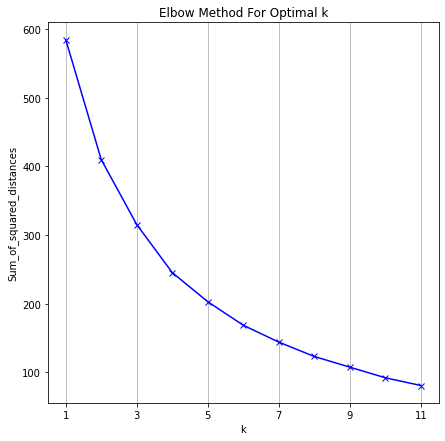

In [16]:
Sum_of_squared_distances = []
n = 12
K = range(1,n)
for k in K:
    km = KMeans(n_clusters=k,random_state=0,init='k-means++',n_init = 1000, max_iter = 5000)
    km = km.fit(data_norm)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(7,7))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xticks(np.arange(1,n,2))
plt.grid(axis='x')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3464599144276961
For n_clusters = 3 The average silhouette_score is : 0.2969275911348457


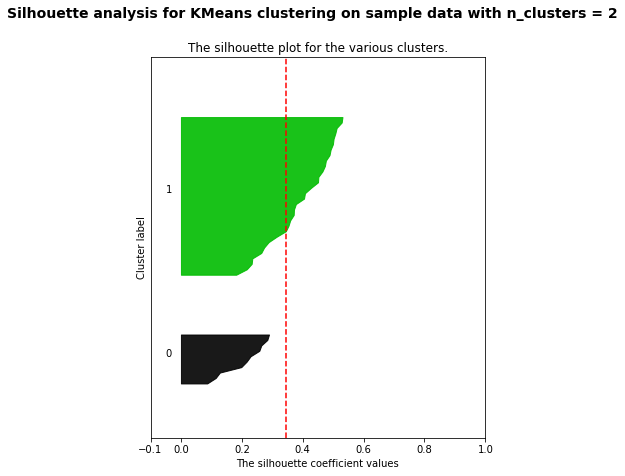

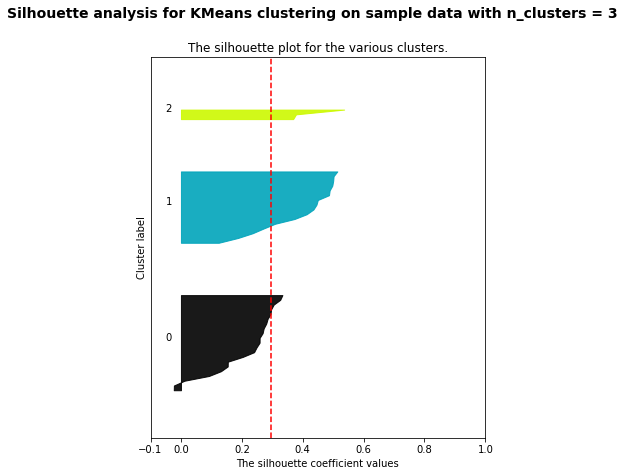

In [17]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

k = 4
range_n_clusters = range(2, k)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,init='k-means++',n_init = 1000, max_iter = 5000)
    cluster_labels = kmeans.fit_predict(data_norm)
    df_dataset_properties['clusters_kmeans'+str(n_clusters)] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The best k is 2! Your can see this in silhouette plot.

In [18]:
k_cluster_selected = 'clusters_kmeans3'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bb0c85910>,
      dtype=object)

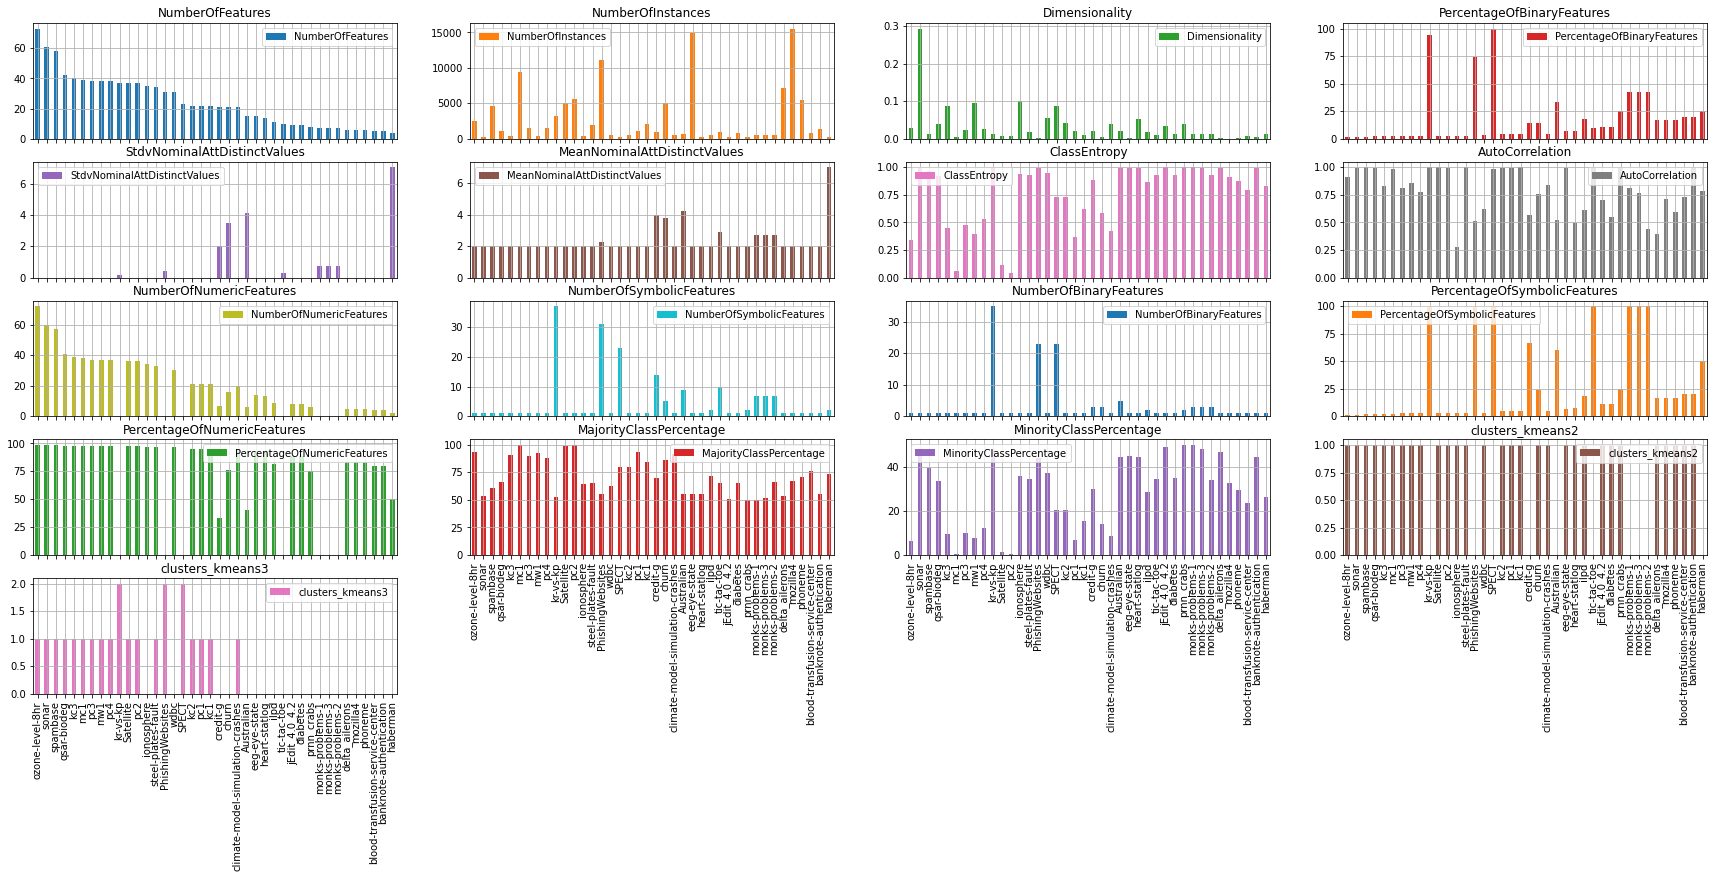

In [19]:
df_dataset_properties.plot(rot=90, subplots=True,layout=(8,4),figsize=(30,20),kind='bar',grid=True)

In [20]:
df_dataset_properties[k_cluster_selected].value_counts()

0    21
1    16
2     3
Name: clusters_kmeans3, dtype: int64

In [21]:
print('Datasets for cluster 0')
df_dataset_properties.query(k_cluster_selected+' == 0').index.to_list()

Datasets for cluster 0


['ionosphere',
 'wdbc',
 'credit-g',
 'churn',
 'Australian',
 'eeg-eye-state',
 'heart-statlog',
 'ilpd',
 'tic-tac-toe',
 'jEdit_4.0_4.2',
 'diabetes',
 'prnn_crabs',
 'monks-problems-1',
 'monks-problems-3',
 'monks-problems-2',
 'delta_ailerons',
 'mozilla4',
 'phoneme',
 'blood-transfusion-service-center',
 'banknote-authentication',
 'haberman']

In [22]:
print('Datasets for cluster 1')
df_dataset_properties.query(k_cluster_selected+' == 1').index.to_list()

Datasets for cluster 1


['ozone-level-8hr',
 'sonar',
 'spambase',
 'qsar-biodeg',
 'kc3',
 'mc1',
 'pc3',
 'mw1',
 'pc4',
 'Satellite',
 'pc2',
 'steel-plates-fault',
 'kc2',
 'pc1',
 'kc1',
 'climate-model-simulation-crashes']

In [23]:
print('Datasets for cluster 2')
df_dataset_properties.query(k_cluster_selected+' == 2').index.to_list()

Datasets for cluster 2


['kr-vs-kp', 'PhishingWebsites', 'SPECT']

In [24]:
data_norm

,NumberOfFeatures,NumberOfInstances,Dimensionality,PercentageOfBinaryFeatures,StdvNominalAttDistinctValues,MeanNominalAttDistinctValues,ClassEntropy,AutoCorrelation,NumberOfNumericFeatures,NumberOfSymbolicFeatures,NumberOfBinaryFeatures,PercentageOfSymbolicFeatures,PercentageOfNumericFeatures,MajorityClassPercentage,MinorityClassPercentage
ozone-level-8hr,2.848911,-0.061990,-0.066022,-0.688876,-0.357970,-0.381777,-1.454469,0.571783,2.766339,-0.437026,-0.333101,-0.726125,0.726125,1.398692,-1.398692
sonar,2.149434,-0.658299,5.225773,-0.677652,-0.357970,-0.381777,0.809535,0.953270,2.133430,-0.437026,-0.333101,-0.718795,0.718795,-1.111117,1.111117
spambase,1.974565,0.467921,-0.390225,-0.674120,-0.357970,-0.381777,0.708320,0.975366,1.975203,-0.437026,-0.333101,-0.716488,0.716488,-0.661066,0.661066
qsar-biodeg,1.041929,-0.441157,0.154129,-0.646764,-0.357970,-0.381777,0.553197,0.962775,1.131324,-0.437026,-0.333101,-0.698622,0.698622,-0.308726,0.308726
kc3,0.925350,-0.594208,1.105108,-0.641805,-0.357970,-0.381777,-1.077030,0.158975,1.025840,-0.437026,-0.333101,-0.695384,0.695384,1.207314,-1.207314
mc1,0.867060,1.715147,-0.560027,-0.639136,-0.357970,-0.381777,-2.413604,0.907590,0.973097,-0.437026,-0.333101,-0.693641,0.693641,1.747009,-1.747009
pc3,0.808770,-0.310922,-0.155986,-0.636325,-0.357970,-0.381777,-0.983483,0.087225,0.920355,-0.437026,-0.333101,-0.691805,0.691805,1.154524,-1.154524
mw1,0.808770,-0.608308,1.244307,-0.636325,-0.357970,-0.381777,-1.277147,0.285411,0.920355,-0.437026,-0.333101,-0.691805,0.691805,1.312905,-1.312905
pc4,0.808770,-0.337841,-0.120951,-0.636325,-0.357970,-0.381777,-0.780601,-0.075467,0.920355,-0.437026,-0.333101,-0.691805,0.691805,1.031788,-1.031788
kr-vs-kp,0.750480,0.107725,-0.410815,3.193940,-0.239927,-0.353016,0.815897,0.971910,-1.031114,3.963791,4.486235,1.956702,-1.956702,-1.182318,1.182318


## MCA

In [25]:
from collections import OrderedDict

import numpy as np
from scipy import linalg


GRAY = OrderedDict([
    ('light', '#bababa'),
    ('dark', '#404040')
])


def stylize_axis(ax, grid=True):

    if grid:
        ax.grid()

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.axhline(y=0, linestyle='-', linewidth=1.2, color=GRAY['dark'], alpha=0.6)
    ax.axvline(x=0, linestyle='-', linewidth=1.2, color=GRAY['dark'], alpha=0.6)

    return ax


def build_ellipse(X, Y):
    """Construct ellipse coordinates from two arrays of numbers.
    Args:
        X (1D array_like)
        Y (1D array_like)
    Returns:
        float: The mean of `X`.
        float: The mean of `Y`.
        float: The width of the ellipse.
        float: The height of the ellipse.
        float: The angle of orientation of the ellipse.
    """
    x_mean = np.mean(X)
    y_mean = np.mean(Y)

    cov_matrix = np.cov(np.vstack((X, Y)))
    U, s, V = linalg.svd(cov_matrix, full_matrices=False)

    chi_95 = np.sqrt(4.61)  # 90% quantile of the chi-square distribution
    width = np.sqrt(cov_matrix[0][0]) * chi_95 * 2
    height = np.sqrt(cov_matrix[1][1]) * chi_95 * 2

    eigenvector = V.T[0]
    angle = np.arctan(eigenvector[1] / eigenvector[0])

    return x_mean, y_mean, width, height, angle

In [26]:
import pandas as pd


def make_labels_and_names(X):

    if isinstance(X, pd.DataFrame):
        row_label = X.index.name if X.index.name else 'Rows'
        row_names = X.index.tolist()
        col_label = X.columns.name if X.columns.name else 'Columns'
        col_names = X.columns.tolist()
    else:
        row_label = 'Rows'
        row_names = list(range(X.shape[0]))
        col_label = 'Columns'
        col_names = list(range(X.shape[1]))

    return row_label, row_names, col_label, col_names

In [27]:
"""Singular Value Decomposition (SVD)"""
try:
    import fbpca
    FBPCA_INSTALLED = True
except ImportError:
    FBPCA_INSTALLED = False
from sklearn.utils import extmath


def compute_svd(X, n_components, n_iter, random_state, engine):
    """Computes an SVD with k components."""

    # Determine what SVD engine to use
    if engine == 'auto':
        engine = 'sklearn'

    # Compute the SVD
    if engine == 'fbpca':
        if FBPCA_INSTALLED:
            U, s, V = fbpca.pca(X, k=n_components, n_iter=n_iter)
        else:
            raise ValueError('fbpca is not installed; please install it if you want to use it')
    elif engine == 'sklearn':
        U, s, V = extmath.randomized_svd(
            X,
            n_components=n_components,
            n_iter=n_iter,
            random_state=random_state
        )
    else:
        raise ValueError("engine has to be one of ('auto', 'fbpca', 'sklearn')")

    U, V = extmath.svd_flip(U, V)

    return U, s, V

In [28]:
"""Correspondence Analysis (CA)"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import base
from sklearn import utils

# from . import plot
# from . import util
# from . import svd


class CA(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, n_components=2, n_iter=10, copy=True, check_input=True, benzecri=False,
                 random_state=None, engine='auto'):
        self.n_components = n_components
        self.n_iter = n_iter
        self.copy = copy
        self.check_input = check_input
        self.random_state = random_state
        self.benzecri = benzecri
        self.engine = engine

    def fit(self, X, y=None):

        # Check input
        if self.check_input:
            utils.check_array(X)

        # Check all values are positive
        if (X < 0).any().any():
            raise ValueError("All values in X should be positive")

        _, row_names, _, col_names = make_labels_and_names(X)

        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        if self.copy:
            X = np.copy(X)

        # Compute the correspondence matrix which contains the relative frequencies
        X = X.astype(float) / np.sum(X)

        # Compute row and column masses
        self.row_masses_ = pd.Series(X.sum(axis=1), index=row_names)
        self.col_masses_ = pd.Series(X.sum(axis=0), index=col_names)

        # Compute standardised residuals
        r = self.row_masses_.to_numpy()
        c = self.col_masses_.to_numpy()
        S = sparse.diags(r ** -.5) @ (X - np.outer(r, c)) @ sparse.diags(c ** -.5)

        # Compute SVD on the standardised residuals
        self.U_, self.s_, self.V_ = compute_svd(
            X=S,
            n_components=self.n_components,
            n_iter=self.n_iter,
            random_state=self.random_state,
            engine=self.engine
        )

        # Compute total inertia
        self.total_inertia_ = np.einsum('ij,ji->', S, S.T)

        return self

    def _check_is_fitted(self):
        utils.validation.check_is_fitted(self, 'total_inertia_')

    def transform(self, X):
        """Computes the row principal coordinates of a dataset.
        Same as calling `row_coordinates`. In most cases you should be using the same
        dataset as you did when calling the `fit` method. You might however also want to included
        supplementary data.
        """
        self._check_is_fitted()
        if self.check_input:
            utils.check_array(X)
        return self.row_coordinates(X)

    @property
    def eigenvalues_(self):
        """The eigenvalues associated with each principal component.
        Benzecri correction is applied if specified.
        """
        self._check_is_fitted()

        K = len(self.col_masses_)

        if self.benzecri:
            return np.array([
                (K / (K - 1.) * (s - 1. / K)) ** 2
                if s > 1. / K else 0
                for s in np.square(self.s_)
            ])

        return np.square(self.s_).tolist()

    @property
    def explained_inertia_(self):
        """The percentage of explained inertia per principal component."""
        self._check_is_fitted()
        return [eig / self.total_inertia_ for eig in self.eigenvalues_]

    def row_coordinates(self, X):
        """The row principal coordinates."""
        self._check_is_fitted()

        _, row_names, _, _ = make_labels_and_names(X)

        if isinstance(X, pd.DataFrame):
            try:
                X = X.sparse.to_coo().astype(float)
            except AttributeError:
                X = X.to_numpy()

        if self.copy:
            X = X.copy()

        # Normalise the rows so that they sum up to 1
        if isinstance(X, np.ndarray):
            X = X / X.sum(axis=1)[:, None]
        else:
            X = X / X.sum(axis=1)

        return pd.DataFrame(
            data=X @ sparse.diags(self.col_masses_.to_numpy() ** -0.5) @ self.V_.T,
            index=row_names
        )

    def column_coordinates(self, X):
        """The column principal coordinates."""
        self._check_is_fitted()

        _, _, _, col_names = make_labels_and_names(X)

        if isinstance(X, pd.DataFrame):
            is_sparse = X.dtypes.apply(pd.api.types.is_sparse).all()
            if is_sparse:
                X = X.sparse.to_coo()
            else:
                X = X.to_numpy()

        if self.copy:
            X = X.copy()

        # Transpose and make sure the rows sum up to 1
        if isinstance(X, np.ndarray):
            X = X.T / X.T.sum(axis=1)[:, None]
        else:
            X = X.T / X.T.sum(axis=1)

        return pd.DataFrame(
            data=X @ sparse.diags(self.row_masses_.to_numpy() ** -0.5) @ self.U_,
            index=col_names
        )

    def plot_coordinates(self, X, ax=None, figsize=(6, 6), x_component=0, y_component=1,
                                   show_row_labels=True, show_col_labels=True, **kwargs):
        """Plot the principal coordinates."""

        self._check_is_fitted()

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        # Add style
        ax = stylize_axis(ax)

        # Get labels and names
        row_label, row_names, col_label, col_names = make_labels_and_names(X)

        # Plot row principal coordinates
        row_coords = self.row_coordinates(X)
        ax.scatter(
            row_coords[x_component],
            row_coords[y_component],
            **kwargs,
            label=row_label
        )

        # Plot column principal coordinates
        col_coords = self.column_coordinates(X)
        ax.scatter(
            col_coords[x_component],
            col_coords[y_component],
            **kwargs,
            label=col_label
        )

        # Add row labels
        if show_row_labels:
            x = row_coords[x_component]
            y = row_coords[y_component]
            for xi, yi, label in zip(x, y, row_names):
                ax.annotate(label, (xi, yi))

        # Add column labels
        if show_col_labels:
            x = col_coords[x_component]
            y = col_coords[y_component]
            for xi, yi, label in zip(x, y, col_names):
                ax.annotate(label, (xi, yi))

        # Legend
        ax.legend()

        # Text
        ax.set_title('Principal coordinates')
        ei = self.explained_inertia_
        ax.set_xlabel('Component {} ({:.2f}% inertia)'.format(x_component, 100 * ei[x_component]))
        ax.set_ylabel('Component {} ({:.2f}% inertia)'.format(y_component, 100 * ei[y_component]))

        return ax

In [29]:
"""Multiple Correspondence Analysis (MCA)"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import utils
from adjustText import adjust_text

# from . import ca
# from . import plot


class MCA(CA):

    def fit(self, X, y=None):

        if self.check_input:
            utils.check_array(X, dtype=[str, np.number])

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        n_initial_columns = X.shape[1]

        # One-hot encode the data
        one_hot = pd.get_dummies(X)

        # Apply CA to the indicator matrix
        super().fit(one_hot)

        # Compute the total inertia
        n_new_columns = one_hot.shape[1]
        self.total_inertia_ = (n_new_columns - n_initial_columns) / n_initial_columns

        return self

    def row_coordinates(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return super().row_coordinates(pd.get_dummies(X))

    def column_coordinates(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return super().column_coordinates(pd.get_dummies(X))

    def transform(self, X):
        """Computes the row principal coordinates of a dataset."""
        self._check_is_fitted()
        if self.check_input:
            utils.check_array(X, dtype=[str, np.number])
        return self.row_coordinates(X)

    def plot_coordinates(self, X, ax=None, figsize=(6, 6), x_component=0, y_component=1,
                         show_row_points=True, row_points_size=10,
                         row_points_alpha=0.6, show_row_labels=False,
                         show_column_points=True, column_points_size=30, show_column_labels=False,
                         legend_n_cols=1, 
                         xlim=(-2,2), 
                         ylim=(-2,2)):
        """Plot row and column principal coordinates.
        Parameters:
            ax (matplotlib.Axis): A fresh one will be created and returned if not provided.
            figsize ((float, float)): The desired figure size if `ax` is not provided.
            x_component (int): Number of the component used for the x-axis.
            y_component (int): Number of the component used for the y-axis.
            show_row_points (bool): Whether to show row principal components or not.
            row_points_size (float): Row principal components point size.
            row_points_alpha (float): Alpha for the row principal component.
            show_row_labels (bool): Whether to show row labels or not.
            show_column_points (bool): Whether to show column principal components or not.
            column_points_size (float): Column principal components point size.
            show_column_labels (bool): Whether to show column labels or not.
            legend_n_cols (int): Number of columns used for the legend.
        Returns:
            matplotlib.Axis
        """

        

        self._check_is_fitted()

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        # Add style
        ax = stylize_axis(ax)

        # Plot row principal coordinates
        if show_row_points or show_row_labels:

            row_coords = self.row_coordinates(X)

            if show_row_points:
                ax.scatter(
                    row_coords.iloc[:, x_component],
                    row_coords.iloc[:, y_component],
                    s=row_points_size,
                    label=None,
                    color=GRAY['dark'],
                    alpha=row_points_alpha
                )
            texts = []
            if show_row_labels:
                for _, row in row_coords.iterrows():
                    if df_dataset_properties.loc[row.name][k_cluster_selected] == 0:
                      texts.append(ax.text(row[x_component], row[y_component], s=row.name, **dict(color='blue', alpha=0.6,fontsize='10')))
                    else:
                      if df_dataset_properties.loc[row.name][k_cluster_selected] == 1:
                        texts.append(ax.text(row[x_component], row[y_component], s=row.name, **dict(color='red', alpha=0.6,fontsize='10')))
                      else:
                        if df_dataset_properties.loc[row.name][k_cluster_selected] == 2:
                          texts.append(ax.text(row[x_component], row[y_component], s=row.name, **dict(color='gray',fontsize='10')))
            #adjust_text(texts)
            

        # Plot column principal coordinates
        if show_column_points or show_column_labels:

            col_coords = self.column_coordinates(X)
            x = col_coords[x_component] 
            y = col_coords[y_component]

            prefixes = col_coords.index.str.split('_').map(lambda x: x[0])
            

            for prefix in prefixes.unique():
                mask = prefixes == prefix

                if show_column_points:
                    ax.scatter(x[mask], y[mask], s=column_points_size, label=prefix)

                if show_column_labels:
                    for i, label in enumerate(col_coords[mask].index):
                       texts.append(ax.text(x[mask][i], y[mask][i],s=label,**dict(fontsize='10')))
            
            
            adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'),expand_text=(1.2,1.3))
            ax.legend(ncol=legend_n_cols,loc='upper left')
            

        # Text
        ax.set_title('Row and column principal coordinates')
        ei = self.explained_inertia_
        ax.set_xlabel('Component {} ({:.2f}% inertia)'.format(x_component, 100 * ei[x_component]))
        ax.set_ylabel('Component {} ({:.2f}% inertia)'.format(y_component, 100 * ei[y_component]))
        plt.xlim(xlim)
        plt.ylim(ylim)
        return ax

In [30]:
df_dataset_properties_copy = df_dataset_properties.copy()
df_dataset_properties_copy = df_dataset_properties_copy.drop(columns=k_cluster_selected)

df_dataset_properties_copy.to_csv('df_properties.csv')
#files.download('df_properties.csv')


In [31]:
for i,c in enumerate(df_dataset_properties_copy.columns):
    try:
      df_dataset_properties_copy[c] = pd.qcut(df_dataset_properties_copy[c], q=2,duplicates='drop',labels=['s','h'])
    except:
      df_dataset_properties_copy[c] = pd.cut(df_dataset_properties_copy[c], bins=2,duplicates='drop',labels=['s','h'])



In [32]:
df_dataset_properties_copy
df_dataset_properties_copy.to_csv('df_properties_binarized.csv')
files.download('df_properties_binarized.csv')

df_dataset_properties_copy = df_dataset_properties_copy.drop(columns='clusters_kmeans2')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
mca = MCA()
mca = mca.fit(df_dataset_properties_copy)

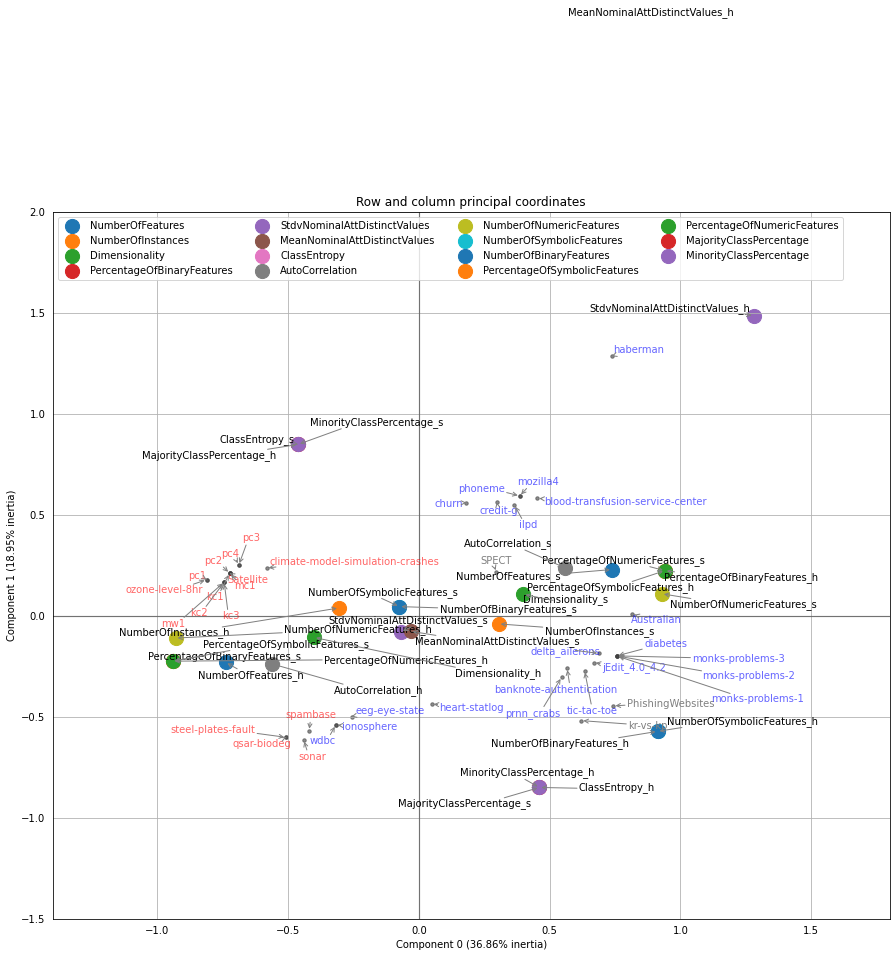

In [34]:
ax = mca.plot_coordinates(
     X=df_dataset_properties_copy,
     ax=None,
     figsize=(15,13),
     show_row_points=True,
     row_points_size=12,
     show_row_labels=True,
     show_column_points=True,
     column_points_size=200,
     show_column_labels=True,
     legend_n_cols=4,
     xlim=(-1.4,1.8),
     ylim=(-1.5,2))

## Main Benchmark Function

In [35]:
do_download_files = do_download

def main_benchmark (code_datasets, df_dataset_properties_cluster,apply_smote=False):
  crossvalidation = 3

  cv_grid_search = crossvalidation


  #This dataset will be complete (with values) only in final of notebook
  dt = {'dataset_name':[],
          'model_name':[],
          'model_params':[],
          'accuracy':[],
          'precision':[],
          'recall':[],
          'correct_true':[],
          'correct_false':[]}
  df_models_info = pd.DataFrame(dt)

  dt = {'dataset_name':[],
          'model_name':[],
          'xai_vs_xai':[],
          'correlation':[]}
  df_resume_boxplot = pd.DataFrame(dt)

  tag_shap_vs_shap = 'shap_vs_shap'
  tag_shap_vs_eli5 = 'shap_vs_eli5'
  shap_vs_dalex = 'shap_vs_dalex'
  tag_shap_vs_ci = 'shap_vs_ci'
  tag_shap_vs_skater = 'shap_vs_skater'
  tag_shap_vs_lofo = 'shap_vs_lofo'
  tag_shap_vs_info_gain = 'shap_vs_info_gain'
  tag_shap_vs_exirt = 'shap_vs_exirt'
  tag_eli5_vs_eli5 = 'eli5_vs_eli5'
  tag_eli5_vs_dalex = 'eli5_vs_dalex'
  tag_eli5_vs_ci = 'eli5_vs_ci'
  tag_eli5_vs_skater = 'eli5_vs_skater'
  tag_eli5_vs_lofo = 'eli5_vs_lofo'
  tag_eli5_vs_info_gain = 'eli5_vs_info_gain'
  tag_eli5_vs_exirt = 'eli5_vs_exirt'
  tag_dalex_vs_dalex = 'dalex_vs_dalex'
  tag_dalex_vs_ci = 'dalex_vs_ci'
  tag_dalex_vs_skater = 'dalex_vs_skater'
  tag_dalex_vs_lofo = 'dalex_vs_lofo'
  tag_dalex_vs_info_gain = 'dalex_vs_info_gain'
  tag_dalex_vs_exirt = 'dalex_vs_exirt'
  tag_ci_vs_ci = 'ci_vs_ci'
  tag_ci_vs_skater = 'ci_vs_skater'
  tag_ci_vs_lofo = 'ci_vs_lofo'
  tag_ci_vs_info_gain = 'ci_vs_info_gain'
  tag_ci_vs_info_gain = 'ci_vs_exirt'
  tag_skater_vs_skater = 'skater_vs_skater'
  tag_skater_vs_lofo = 'skater_vs_lofo'
  tag_skater_vs_info_gain = 'skater_vs_info_gain'
  tag_lofo_vs_lofo = 'lofo_vs_lofo'
  tag_lofo_vs_info_gain = 'lofo_vs_info_gain'
  tag_lofo_vs_info_gain = 'lofo_vs_exirt'
  tag_info_gain_vs_info_gain = 'info_gain_vs_info_gain'
  tag_info_gain_vs_exirt = 'info_gain_vs_exirt'
  tag_exirt_vs_exirt = 'exirt_vs_exirt'

  #Global analyses resume

  #rf
  lt_rf_shap_vs_shap = []
  lt_rf_shap_vs_eli5 = []
  lt_rf_shap_vs_dalex = []
  lt_rf_shap_vs_ci = []
  lt_rf_shap_vs_skater = []
  lt_rf_shap_vs_lofo = []
  lt_rf_shap_vs_info_gain = []
  lt_rf_shap_vs_exirt = []
  lt_rf_eli5_vs_eli5 = []
  lt_rf_eli5_vs_dalex = []
  lt_rf_eli5_vs_ci = []
  lt_rf_eli5_vs_skater = []
  lt_rf_eli5_vs_lofo = []
  lt_rf_eli5_vs_info_gain = []
  lt_rf_eli5_vs_exirt = []
  lt_rf_dalex_vs_dalex = []
  lt_rf_dalex_vs_ci = []
  lt_rf_dalex_vs_skater = []
  lt_rf_dalex_vs_lofo = []
  lt_rf_dalex_vs_info_gain = []
  lt_rf_dalex_vs_exirt = []
  lt_rf_ci_vs_ci = []
  lt_rf_ci_vs_skater = []
  lt_rf_ci_vs_lofo = []
  lt_rf_ci_vs_info_gain = []
  lt_rf_ci_vs_exirt = []
  lt_rf_skater_vs_skater = []
  lt_rf_skater_vs_lofo = []
  lt_rf_skater_vs_info_gain = []
  lt_rf_skater_vs_exirt = []
  lt_rf_lofo_vs_lofo = []
  lt_rf_lofo_vs_info_gain = []
  lt_rf_lofo_vs_exirt = []
  lt_rf_info_gain_vs_info_gain = []
  lt_rf_info_gain_vs_exirt = []
  lt_rf_exirt_vs_exirt = []

  #gb
  lt_gb_shap_vs_shap = []
  lt_gb_shap_vs_eli5 = []
  lt_gb_shap_vs_dalex = []
  lt_gb_shap_vs_ci = []
  lt_gb_shap_vs_skater = []
  lt_gb_shap_vs_lofo = []
  lt_gb_shap_vs_info_gain = []
  lt_gb_shap_vs_exirt = []
  lt_gb_eli5_vs_eli5 = []
  lt_gb_eli5_vs_dalex = []
  lt_gb_eli5_vs_ci = []
  lt_gb_eli5_vs_skater = []
  lt_gb_eli5_vs_lofo = []
  lt_gb_eli5_vs_info_gain = []
  lt_gb_eli5_vs_exirt = []
  lt_gb_dalex_vs_dalex = []
  lt_gb_dalex_vs_ci = []
  lt_gb_dalex_vs_skater = []
  lt_gb_dalex_vs_lofo = []
  lt_gb_dalex_vs_info_gain = []
  lt_gb_dalex_vs_exirt = []
  lt_gb_ci_vs_ci = []
  lt_gb_ci_vs_skater = []
  lt_gb_ci_vs_lofo = []
  lt_gb_ci_vs_info_gain = []
  lt_gb_ci_vs_exirt = []
  lt_gb_skater_vs_skater = []
  lt_gb_skater_vs_lofo = []
  lt_gb_skater_vs_info_gain = []
  lt_gb_skater_vs_exirt = []
  lt_gb_lofo_vs_lofo = []
  lt_gb_lofo_vs_info_gain = []
  lt_gb_lofo_vs_exirt = []
  lt_gb_info_gain_vs_info_gain = []
  lt_gb_info_gain_vs_exirt = []
  lt_gb_exirt_vs_exirt = []




  #dt
  lt_dt_shap_vs_shap = []
  lt_dt_shap_vs_eli5 = []
  lt_dt_shap_vs_dalex = []
  lt_dt_shap_vs_ci = []
  lt_dt_shap_vs_skater = []
  lt_dt_shap_vs_lofo = []
  lt_dt_shap_vs_info_gain = []
  lt_dt_shap_vs_exirt = []
  lt_dt_eli5_vs_eli5 = []
  lt_dt_eli5_vs_dalex = []
  lt_dt_eli5_vs_ci = []
  lt_dt_eli5_vs_skater = []
  lt_dt_eli5_vs_lofo = []
  lt_dt_eli5_vs_info_gain = []
  lt_dt_eli5_vs_exirt = []
  lt_dt_dalex_vs_dalex = []
  lt_dt_dalex_vs_ci = []
  lt_dt_dalex_vs_skater = []
  lt_dt_dalex_vs_lofo = []
  lt_dt_dalex_vs_info_gain = []
  lt_dt_dalex_vs_exirt = []
  lt_dt_ci_vs_ci = []
  lt_dt_ci_vs_skater = []
  lt_dt_ci_vs_lofo = []
  lt_dt_ci_vs_info_gain = []
  lt_dt_ci_vs_exirt = []
  lt_dt_skater_vs_skater = []
  lt_dt_skater_vs_lofo = []
  lt_dt_skater_vs_info_gain = []
  lt_dt_skater_vs_exirt = []
  lt_dt_lofo_vs_lofo = []
  lt_dt_lofo_vs_info_gain = []
  lt_dt_lofo_vs_exirt = []
  lt_dt_info_gain_vs_info_gain = []
  lt_dt_info_gain_vs_exirt = []
  lt_dt_exirt_vs_exirt = []




  #if run_train_test_model_* is False the upload of model is required
  run_train_test_model_rf = True
  run_train_test_model_gb = True
  run_train_test_model_dt = True

  crossvalidation = 10

  save_split_train_test_data = True

  #Import datasets
  #datasets_df = openml.datasets.list_datasets(output_format="dataframe")
  #print(datasets_df.head(n=10))

  #datasets excluidos
  #mc2 , analcatdata_boxing2 , datatrieve , analcatdata_creditscore 
  #servo, aids , ar6,ar4(ERRO no skater pois possui atributos constantes)


  print('## Execution of benchmark to: ')
  print(code_datasets)

  ind = 0

  for i in range(len(code_datasets)):
          
          df_models_info.loc[ind,'dataset_name'] = str(code_datasets[i])
          df_models_info.loc[ind+1,'dataset_name'] = str(code_datasets[i])
          df_models_info.loc[ind+2,'dataset_name'] = str(code_datasets[i])
          df_models_info.loc[ind+3,'dataset_name'] = str(code_datasets[i])


          
          dataset = openml.datasets.get_dataset(code_datasets[i])
          
          print(dataset.get_data)
          
          X, Y, categorical_indicator, attribute_names = dataset.get_data(
                  dataset_format="dataframe", target=dataset.default_target_attribute)
          
        

          dt = {'att_original_names':[],
                'shap_rf':[],
                'shap_gb':[],
                'shap_dt':[],
                'eli5_rf':[],
                'eli5_gb':[],
                'eli5_dt':[],
                'dalex_rf':[],
                'dalex_gb':[],
                'dalex_dt':[],
                'ci_rf':[],
                'ci_gb':[],
                'ci_dt':[],
                'skater_rf':[],
                'skater_gb':[],
                'skater_dt':[],
                'lofo_rf':[],
                'lofo_gb':[],
                'lofo_dt':[],
                'info_gain_rf':[],
                'info_gain_gb':[],
                'info_gain_dt':[],
                'exirt_rf':[],
                'exirt_gb':[],
                'exirt_dt':[]}
          df_feature_rank = pd.DataFrame(dt)
          df_feature_rank['att_original_names'] = attribute_names
          
          
          #pre-process
          X = PreprocessDefault.PreprocessXByDataset(X,code_datasets[i])
          Y = PreprocessDefault.PreprocessYByDataset(Y,code_datasets[i])
          attribute_names = X.columns.to_list() #fix error 

          
          #normalize data by min-max
          X = PreprocessDefault.normalize(X)

          #Apply SMOTE to balance the classes
          if apply_smote:
            print('Appling SMOTE...')
            oversample = SMOTE() #deprecated
            col_x = X.columns
            X, Y = oversample.fit_resample(X, Y)
            X = pd.DataFrame(X, columns=col_x)
            Y = pd.Series(Y)

          #print("pos processado")
          print(X.head(n=100))

          #create context dictionary (necessary to CIU)
          context_dic = {}
          for k in range(len(attribute_names)):
            context_dic[attribute_names[k]] = [min(X[attribute_names[k]]), max(X[attribute_names[k]]), Util.is_int(X[attribute_names[k]])]

          # percentage = 0.3 # 30%
          # if len(Y)*0.3 >= 500:
          #   percentage = 0.05 # 5%
          

          #split data
          X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y) # 95% training and 5% test
          

          if save_split_train_test_data == True:
              name_dataset = code_datasets[i]
              
              if do_download_files == True:
                X_train.to_csv("X_train_"+name_dataset+".csv")
                files.download("X_train_"+name_dataset+".csv") 
                
                X_test.to_csv("X_test_"+name_dataset+".csv")
                files.download("X_test_"+name_dataset+".csv") 

                y_train.to_csv("y_train_"+name_dataset+".csv")
                files.download("y_train_"+name_dataset+".csv") 

                y_test.to_csv("y_test_"+name_dataset+".csv")
                files.download("y_test_"+name_dataset+".csv") 


          #execution of model RF
          
          file_name = 'model_rf_'+code_datasets[i]+'.sav'
          
          df_models_info.loc[ind+1,'model_name'] = 'RF'
          
          if run_train_test_model_rf == True:
            
            param_grid = {
                'max_depth': [1, 10],#
                'bootstrap': [True, False],#
                'n_estimators': [100, 200],#
                'min_samples_leaf': [1, 10],#
                'min_samples_split':[2,10],#
                #'ccp_alpha': [0.0, 0.4], #remover
                #'criterion': ['gini', 'entropy'], #remover
                'max_features': ['sqrt', 'log2']#
            }


            # Create a based model
            model_rf = RandomForestClassifier()
            # Instantiate the grid search model
            #https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
            grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid, 
                                      cv = StratifiedKFold(cv_grid_search), n_jobs = 3, 
                                       verbose = 2,scoring = 'roc_auc')

            
            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)
            
            grid_search.best_params_

            model_rf = grid_search.best_estimator_

            model_rf_copy_1 = grid_search.best_estimator_
            
            #save model
            pickle.dump(model_rf, open(file_name, 'wb'))
            if do_download_files == True:
              files.download(file_name)
          else:
            model_rf = pickle.load(open(file_name, 'rb'))
          
          y_pred_rf=model_rf.predict(X_test)
          print(model_rf)
          df_models_info.loc[ind+1,'model_params'] = str(model_rf.get_params())
          
          #analysis precision, accuracy and recall
          ac, pr, re = AnalysisDefault.calcAccuracyPrecisionRecallByModel(y_test,y_pred_rf)
          
          df_models_info.loc[ind+1,'accuracy'] = ac
          df_models_info.loc[ind+1,'precision'] = pr
          df_models_info.loc[ind+1,'recall'] = re
          
          #confusion matrix
          tp, tn = AnalysisDefault.calcConfusionMatrix(y_test,y_pred_rf,"rf")
          df_models_info.loc[ind+1,'correct_true'] = tp
          df_models_info.loc[ind+1,'correct_false'] = tn
          
          
          #statistical analysis
          hit_rates = AnalysisDefault.calcCrossValidation(model_rf,X_train, y_train, crossvalidation, False)
          hit_rates_rf = hit_rates
          
          #execution of model GB
          
          file_name = 'model_gb_'+code_datasets[i]+'.sav'
          
          df_models_info.loc[ind+2,'model_name'] = 'GB'
          
          if run_train_test_model_gb == True:
            param_grid = {
                'max_depth': [1, 10],#
                'n_estimators': [100, 200],#
                'min_samples_leaf': [1, 10],#
                'min_samples_split':[2,10],#
                #'learning_rate': [0.1, 0.5], #remover

                'loss': ['deviance', 'exponential'],#
                #'criterion': ['friedman_mse', 'mse', 'mae'], #remover
                'max_features': [ 'sqrt', 'log2']#
                }

            # Create a based model
            model_gb = GradientBoostingClassifier()

            # Instantiate the grid search model
            grid_search = GridSearchCV(estimator = model_gb, param_grid = param_grid, 
                                      cv = StratifiedKFold(cv_grid_search), n_jobs = 3, verbose = 2,scoring = 'roc_auc')


            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)
            grid_search.best_params_

            model_gb = grid_search.best_estimator_  
            
            #save model
            pickle.dump(model_gb, open(file_name, 'wb'))
            if do_download_files == True:
              files.download(file_name)
          else:
            model_rf = pickle.load(open(file_name, 'rb'))
          
          y_pred_gb=model_gb.predict(X_test)
          print(model_gb)
          
          df_models_info.loc[ind+2,'model_params'] = str(model_gb.get_params())
          
          
          #analysis precision, accuracy and recall
          ac, pr, re = AnalysisDefault.calcAccuracyPrecisionRecallByModel(y_test,y_pred_gb)
          
          df_models_info.loc[ind+2,'accuracy'] = ac
          df_models_info.loc[ind+2,'precision'] = pr
          df_models_info.loc[ind+2,'recall'] = re
          
          #confusion matrix
          tp, tn = AnalysisDefault.calcConfusionMatrix(y_test,y_pred_gb,"gb")
          df_models_info.loc[ind+2,'correct_true'] = tp
          df_models_info.loc[ind+2,'correct_false'] = tn
          
          #statistical analysis
          hit_rates = AnalysisDefault.calcCrossValidation(model_gb,X_train, y_train, crossvalidation, False)
          hit_rates_gb = hit_rates
          
          #execution of model DT
          
          file_name = 'model_dt_'+code_datasets[i]+'.sav'
          
          df_models_info.loc[ind+3,'model_name'] = 'DT'
          
          if run_train_test_model_dt == True:
            param_grid = { 
                'min_samples_leaf': [1, 10, 20, 40],
                'max_depth': [1, 6, 12],
                #'criterion':['gini','entropy'], #remover
                'splitter':['best', 'random'],
                'min_samples_split': [2, 5, 15, 20, 30],
                'max_features': [ 'sqrt', 'log2']#
                }

            # Create a based model
            model_dt = DecisionTreeClassifier()

            # Instantiate the grid search model
            grid_search = GridSearchCV(estimator = model_dt, param_grid = param_grid, 
                                      cv = StratifiedKFold(cv_grid_search), n_jobs = 3, verbose = 2,scoring = 'roc_auc')

            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)
            grid_search.best_params_

            model_dt = grid_search.best_estimator_
            
            #save model
            pickle.dump(model_dt, open(file_name, 'wb'))
            if do_download_files == True:
              files.download(file_name)
          else:
            model_dt = pickle.load(open(file_name, 'rb'))
          
          y_pred_dt=model_dt.predict(X_test)
          print(model_dt)
          
          df_models_info.loc[ind+3,'model_params'] = str(model_dt.get_params())
          
          #analysis precision, accuracy and recall
          ac, pr, re = AnalysisDefault.calcAccuracyPrecisionRecallByModel(y_test,y_pred_dt)
              
          df_models_info.loc[ind+3,'accuracy'] = ac
          df_models_info.loc[ind+3,'precision'] = pr
          df_models_info.loc[ind+3,'recall'] = re
          
          #confusion matrix
          tp, tn = AnalysisDefault.calcConfusionMatrix(y_test,y_pred_dt,"dt")
          df_models_info.loc[ind+3,'correct_true'] = tp
          df_models_info.loc[ind+3,'correct_false'] = tn
          
          
          #statistical analysis
          hit_rates = AnalysisDefault.calcCrossValidation(model_dt,X_train, y_train, crossvalidation, False)
          hit_rates_dt = hit_rates
          
          
          #statisticals comparations
          name = str("fig_crossval_dataset_"+code_datasets[i]+".png")
          AnalysisDefault.plotComparationCrossValidation(hit_rates_rf,hit_rates_gb,hit_rates_dt,name)
          
        
          name = str("fig_friedman_dataset_"+code_datasets[i]+".png")
          AnalysisDefault.plotFriedmanTest(hit_rates_rf,hit_rates_gb,hit_rates_dt,name)        
          

          #explanation by tree shap
          print('Shap explaning...')
          df_feature_rank['shap_rf'] = ExplainableTools.explainRankByTreeShap(model_rf, attribute_names, X_test)
          df_feature_rank['shap_gb'] = ExplainableTools.explainRankByTreeShap(model_gb,attribute_names, X_test, True)
          df_feature_rank['shap_dt'] = ExplainableTools.explainRankByTreeShap(model_dt,attribute_names, X_test)      

          #explanation by eli5
          print('Eli5 explaning...')
          df_feature_rank['eli5_rf'] = ExplainableTools.explainRankByEli5(model_rf, attribute_names)
          df_feature_rank['eli5_gb'] = ExplainableTools.explainRankByEli5(model_gb, attribute_names)
          df_feature_rank['eli5_dt'] = ExplainableTools.explainRankByEli5(model_dt, attribute_names)
          

          #explanation by dalex
          print('Dalex explaning...')
          df_feature_rank['dalex_rf'] = ExplainableTools.explainRankDalex(model_rf,X_test, y_test)
          df_feature_rank['dalex_gb'] = ExplainableTools.explainRankDalex(model_gb,X_test, y_test)
          df_feature_rank['dalex_dt'] = ExplainableTools.explainRankDalex(model_dt,X_test, y_test)

          #explanation by ci
          print('CI explaning...')
          df_feature_rank['ci_rf'] = ExplainableTools.explainRankByCiu(model_rf, X_test, attribute_names, context_dic,rank='ci')
          df_feature_rank['ci_gb'] = ExplainableTools.explainRankByCiu(model_gb, X_test, attribute_names, context_dic,rank='ci')
          df_feature_rank['ci_dt'] = ExplainableTools.explainRankByCiu(model_dt, X_test, attribute_names, context_dic,rank='ci')
  
          #explanation by skater
          print('Skater explaning...')
          df_feature_rank['skater_rf'] = ExplainableTools.explainRankSkater(model_rf, X_test, attribute_names)
          df_feature_rank['skater_gb'] = ExplainableTools.explainRankSkater(model_gb, X_test, attribute_names)
          df_feature_rank['skater_dt'] = ExplainableTools.explainRankSkater(model_dt, X_test, attribute_names)

          #explanation by lofo
          print('Lofo explaning...')
          df_feature_rank['lofo_rf'] = ExplainableTools.explainRankByLofo(model_rf, X_test, y_test, attribute_names)
          df_feature_rank['lofo_gb'] = ExplainableTools.explainRankByLofo(model_gb, X_test, y_test, attribute_names)
          df_feature_rank['lofo_dt'] = ExplainableTools.explainRankByLofo(model_dt, X_test, y_test, attribute_names)
          

          #explanation by exirt
          print('eXirt explaning...')
          df_feature_rank['exirt_rf'] = explainRankByXAIIRT(model_rf, X_train, X_test, y_train, y_test)
          df_feature_rank['exirt_gb'] = explainRankByXAIIRT(model_gb, X_train, X_test, y_train, y_test)
          df_feature_rank['exirt_dt'] = explainRankByXAIIRT(model_dt, X_train, X_test, y_train, y_test)
          
          #explanation by info gain
          print('Infomation gain rank...')
          df_feature_rank['info_gain_rf'] = ExplainableTools.explainRankByInfoGain(X_test, y_test, attribute_names)
          df_feature_rank['info_gain_gb'] = ExplainableTools.explainRankByInfoGain(X_test, y_test, attribute_names)
          df_feature_rank['info_gain_dt'] = ExplainableTools.explainRankByInfoGain(X_test, y_test, attribute_names)


          #spearman correlation rf

          dt = {'tool':['shap_rf','eli5_rf','dalex_rf','ci_rf','skater_rf','lofo_rf','info_gain_rf', 'exirt_rf'],
                'shap_rf':[0,0,0,0,0,0,0,0],
                'eli5_rf':[0,0,0,0,0,0,0,0],
                'dalex_rf':[0,0,0,0,0,0,0,0],
                'ci_rf':[0,0,0,0,0,0,0,0],
                'skater_rf':[0,0,0,0,0,0,0,0],
                'lofo_rf':[0,0,0,0,0,0,0,0],
                'info_gain_rf':[0,0,0,0,0,0,0,0],
                'exirt_rf':[0,0,0,0,0,0,0,0],
                }
          df_spearman_correlations_rf = pd.DataFrame(dt)
          df_spearman_correlations_rf = df_spearman_correlations_rf.set_index('tool')

          
          for d1 in df_spearman_correlations_rf.columns.to_list():
            for d2 in df_spearman_correlations_rf.columns.to_list():
              
              df_spearman_correlations_rf.loc[d1,d2] =  AnalysisDefault.calcSpearmanCoef(df_feature_rank[d1],df_feature_rank[d2])    

              if d1.find('shap') != -1 and d2.find('shap') != -1:
                lt_rf_shap_vs_shap.append(df_spearman_correlations_rf.loc[d1,d2])
              else:
                if d1.find('shap') != -1 and d2.find('eli5') != -1:
                  lt_rf_shap_vs_eli5.append(df_spearman_correlations_rf.loc[d1,d2])
                else:
                  if d1.find('shap') != -1 and d2.find('dalex') != -1:
                    lt_rf_shap_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                  else:
                    if d1.find('shap') != -1 and d2.find('ci') != -1:
                      lt_rf_shap_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                    else:
                      if d1.find('shap') != -1 and d2.find('skater') != -1:
                        lt_rf_shap_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                      else:
                        if d1.find('shap') != -1 and d2.find('lofo') != -1:
                          lt_rf_shap_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                        else:
                          if d1.find('shap') != -1 and d2.find('gain') != -1:
                            lt_rf_shap_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                          else:
                            if d1.find('shap') != -1 and d2.find('exirt') != -1:
                              lt_rf_shap_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                            else:
                              if d1.find('eli5') != -1 and d2.find('eli5') != -1:
                                lt_rf_eli5_vs_eli5.append(df_spearman_correlations_rf.loc[d1,d2])
                              else:
                                if d1.find('eli5') != -1 and d2.find('dalex') != -1:
                                  lt_rf_eli5_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                                else:
                                  if d1.find('eli5') != -1 and d2.find('ci') != -1:
                                    lt_rf_eli5_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                  else:
                                    if d1.find('eli5') != -1 and d2.find('skater') != -1:
                                      lt_rf_eli5_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                    else:
                                      if d1.find('eli5') != -1 and d2.find('lofo') != -1:
                                        lt_rf_eli5_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                      else:
                                        if d1.find('eli5') != -1 and d2.find('gain') != -1:
                                          lt_rf_eli5_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                                        else:
                                          if d1.find('eli5') != -1 and d2.find('exirt') != -1:
                                            lt_rf_eli5_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                                          else:
                                            if d1.find('dalex') != -1 and d2.find('dalex') != -1:
                                              lt_rf_dalex_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                                            else:
                                              if d1.find('dalex') != -1 and d2.find('ci') != -1:
                                                lt_rf_dalex_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                              else:
                                                if d1.find('dalex') != -1 and d2.find('skater') != -1:
                                                  lt_rf_dalex_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                else:
                                                  if d1.find('dalex') != -1 and d2.find('lofo') != -1:
                                                    lt_rf_dalex_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                  else:
                                                    if d1.find('dalex') != -1 and d2.find('gain') != -1:
                                                      lt_rf_dalex_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                                                    else:
                                                      if d1.find('dalex') != -1 and d2.find('exirt') != -1:
                                                        lt_rf_dalex_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                                                      else:
                                                        if d1.find('ci') != -1 and d2.find('ci') != -1:
                                                          lt_rf_ci_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                                        else:
                                                          if d1.find('ci') != -1 and d2.find('skater') != -1:
                                                            lt_rf_ci_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                          else:
                                                            if d1.find('ci') != -1 and d2.find('lofo') != -1:
                                                              lt_rf_ci_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                            else:
                                                              if d1.find('ci') != -1 and d2.find('gain') != -1:
                                                                lt_rf_ci_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                                                              else:
                                                                if d1.find('ci') != -1 and d2.find('exirt') != -1:
                                                                  lt_rf_ci_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                else:
                                                                  if d1.find('skater') != -1 and d2.find('skater') != -1:
                                                                    lt_rf_skater_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                  else:
                                                                    if d1.find('skater') != -1 and d2.find('lofo') != -1:
                                                                      lt_rf_skater_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                    else:
                                                                      if d1.find('skater') != -1 and d2.find('gain') != -1:
                                                                        lt_rf_skater_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                      else:
                                                                        if d1.find('skater') != -1 and d2.find('exirt') != -1:
                                                                          lt_rf_skater_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                        else:
                                                                          if d1.find('lofo') != -1 and d2.find('lofo') != -1:
                                                                            lt_rf_lofo_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                          else:
                                                                            if d1.find('lofo') != -1 and d2.find('gain') != -1:
                                                                              lt_rf_lofo_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                            else:
                                                                              if d1.find('lofo') != -1 and d2.find('exirt') != -1:
                                                                                lt_rf_lofo_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                              else:
                                                                                if d1.find('gain') != -1 and d2.find('gain') != -1:
                                                                                  lt_rf_info_gain_vs_info_gain.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                else:
                                                                                  if d1.find('gain') != -1 and d2.find('exirt') != -1:
                                                                                    lt_rf_info_gain_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                  else:
                                                                                    if d1.find('exirt') != -1 and d2.find('exirt') != -1:
                                                                                      lt_rf_exirt_vs_exirt.append(df_spearman_correlations_rf.loc[d1,d2])



          df_spearman_correlations_rf = df_spearman_correlations_rf.reset_index()
          minSp = -0.7
          maxSp = 0.7
          sns.heatmap(df_spearman_correlations_rf.drop(columns='tool').values,xticklabels=df_spearman_correlations_rf['tool'].values,yticklabels=df_spearman_correlations_rf['tool'].values, vmin=minSp, vmax=maxSp,cmap="RdYlGn",linewidths=.5,annot=True)

          if do_download_files == True:
            name_fig = "fig_spearman_coeficients_matrix_"+code_datasets[i]+"_rf.png"
            plt.savefig(name_fig)
            files.download(name_fig)
          plt.show()
          
          if do_download_files == True:
            name_df = "df_spearman_coeficients_matrix_"+code_datasets[i]+"_rf.csv"
            df_spearman_correlations_rf.to_csv(name_df)
            files.download(name_df) 


          #spearman correlation gb

          dt = {'tool':['shap_gb','eli5_gb','dalex_gb','ci_gb','skater_gb','lofo_gb','info_gain_gb', 'exirt_gb'],
                'shap_gb':  [0,0,0,0,0,0,0,0],
                'eli5_gb':  [0,0,0,0,0,0,0,0],
                'dalex_gb': [0,0,0,0,0,0,0,0],
                'ci_gb':    [0,0,0,0,0,0,0,0],
                'skater_gb':[0,0,0,0,0,0,0,0],
                'lofo_gb':  [0,0,0,0,0,0,0,0],
                'info_gain_gb':[0,0,0,0,0,0,0,0],
                'exirt_gb': [0,0,0,0,0,0,0,0]
                }



          df_spearman_correlations_gb = pd.DataFrame(dt)
          df_spearman_correlations_gb = df_spearman_correlations_gb.set_index('tool')

          
          for d1 in df_spearman_correlations_gb.columns.to_list():
            for d2 in df_spearman_correlations_gb.columns.to_list():
              #print("")
              #print('###  Features: ',d1,' vs ', d2,' ###')
              df_spearman_correlations_gb.loc[d1,d2] =  AnalysisDefault.calcSpearmanCoef(df_feature_rank[d1],df_feature_rank[d2])
              
              if d1.find('shap') != -1 and d2.find('shap') != -1:
                lt_gb_shap_vs_shap.append(df_spearman_correlations_gb.loc[d1,d2])
              else:
                if d1.find('shap') != -1 and d2.find('eli5') != -1:
                  lt_gb_shap_vs_eli5.append(df_spearman_correlations_gb.loc[d1,d2])
                else:
                  if d1.find('shap') != -1 and d2.find('dalex') != -1:
                    lt_gb_shap_vs_dalex.append(df_spearman_correlations_gb.loc[d1,d2])
                  else:
                    if d1.find('shap') != -1 and d2.find('ci') != -1:
                      lt_gb_shap_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                    else:
                      if d1.find('shap') != -1 and d2.find('skater') != -1:
                        lt_gb_shap_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                      else:
                        if d1.find('shap') != -1 and d2.find('lofo') != -1:
                          lt_gb_shap_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                        else:
                          if d1.find('shap') != -1 and d2.find('gain') != -1:
                            lt_gb_shap_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                          else:
                            if d1.find('shap') != -1 and d2.find('exirt') != -1:
                              lt_gb_shap_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                            else:
                              if d1.find('eli5') != -1 and d2.find('eli5') != -1:
                                lt_gb_eli5_vs_eli5.append(df_spearman_correlations_gb.loc[d1,d2])
                              else:
                                if d1.find('eli5') != -1 and d2.find('dalex') != -1:
                                  lt_gb_eli5_vs_dalex.append(df_spearman_correlations_gb.loc[d1,d2])
                                else:
                                  if d1.find('eli5') != -1 and d2.find('ci') != -1:
                                    lt_gb_eli5_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                                  else:
                                    if d1.find('eli5') != -1 and d2.find('skater') != -1:
                                      lt_gb_eli5_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                    else:
                                      if d1.find('eli5') != -1 and d2.find('lofo') != -1:
                                        lt_gb_eli5_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                      else:
                                        if d1.find('eli5') != -1 and d2.find('gain') != -1:
                                          lt_gb_eli5_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                                        else:
                                          if d1.find('eli5') != -1 and d2.find('exirt') != -1:
                                            lt_gb_eli5_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                                          else:
                                            if d1.find('dalex') != -1 and d2.find('dalex') != -1:
                                              lt_gb_dalex_vs_dalex.append(df_spearman_correlations_gb.loc[d1,d2])
                                            else:
                                              if d1.find('dalex') != -1 and d2.find('ci') != -1:
                                                lt_gb_dalex_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                                              else:
                                                if d1.find('dalex') != -1 and d2.find('skater') != -1:
                                                  lt_gb_dalex_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                                else:
                                                  if d1.find('dalex') != -1 and d2.find('lofo') != -1:
                                                    lt_gb_dalex_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                  else:
                                                    if d1.find('dalex') != -1 and d2.find('gain') != -1:
                                                      lt_gb_dalex_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                                                    else:
                                                      if d1.find('dalex') != -1 and d2.find('exirt') != -1:
                                                        lt_gb_dalex_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                                                      else:
                                                        if d1.find('ci') != -1 and d2.find('ci') != -1:
                                                          lt_gb_ci_vs_ci.append(df_spearman_correlations_gb.loc[d1,d2])
                                                        else:
                                                          if d1.find('ci') != -1 and d2.find('skater') != -1:
                                                            lt_gb_ci_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                                          else:
                                                            if d1.find('ci') != -1 and d2.find('lofo') != -1:
                                                              lt_gb_ci_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                            else:
                                                              if d1.find('ci') != -1 and d2.find('gain') != -1:
                                                                lt_gb_ci_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                                                              else:
                                                                if d1.find('ci') != -1 and d2.find('exirt') != -1:
                                                                  lt_gb_ci_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                else:
                                                                  if d1.find('skater') != -1 and d2.find('skater') != -1:
                                                                    lt_gb_skater_vs_skater.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                  else:
                                                                    if d1.find('skater') != -1 and d2.find('lofo') != -1:
                                                                      lt_gb_skater_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                    else:
                                                                      if d1.find('skater') != -1 and d2.find('gain') != -1:
                                                                        lt_gb_skater_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                      else:
                                                                        if d1.find('skater') != -1 and d2.find('exirt') != -1:
                                                                          lt_gb_skater_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                        else:
                                                                          if d1.find('lofo') != -1 and d2.find('lofo') != -1:
                                                                            lt_gb_lofo_vs_lofo.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                          else:
                                                                            if d1.find('lofo') != -1 and d2.find('gain') != -1:
                                                                              lt_gb_lofo_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                            else:
                                                                              if d1.find('lofo') != -1 and d2.find('exirt') != -1:
                                                                                lt_gb_lofo_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                              else:
                                                                                if d1.find('gain') != -1 and d2.find('gain') != -1:
                                                                                  lt_gb_info_gain_vs_info_gain.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                                else:
                                                                                  if d1.find('gain') != -1 and d2.find('exirt') != -1:
                                                                                    lt_gb_info_gain_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])
                                                                                  else:
                                                                                    if d1.find('exirt') != -1 and d2.find('exirt') != -1:
                                                                                      lt_gb_exirt_vs_exirt.append(df_spearman_correlations_gb.loc[d1,d2])






          df_spearman_correlations_gb = df_spearman_correlations_gb.reset_index()
          sns.heatmap(df_spearman_correlations_gb.drop(columns='tool').values,xticklabels=df_spearman_correlations_gb['tool'].values,yticklabels=df_spearman_correlations_gb['tool'].values, vmin=minSp, vmax=maxSp,cmap="RdYlGn",linewidths=.5,annot=True)


          if do_download_files == True:
            name_fig = "fig_spearman_coeficients_matrix_"+code_datasets[i]+"_gb.png"
            plt.savefig(name_fig)
            files.download(name_fig)
          plt.show()
          
          if do_download_files == True:
            name_df = "df_spearman_coeficients_matrix_"+code_datasets[i]+"_gb.csv"
            df_spearman_correlations_gb.to_csv(name_df)
            files.download(name_df) 


          #spearman correlation dt

          dt = {'tool':['shap_dt','eli5_dt','dalex_dt','ci_dt','skater_dt','lofo_dt','info_gain_dt','exirt_dt'],
                'shap_dt':  [0,0,0,0,0,0,0,0],
                'eli5_dt':  [0,0,0,0,0,0,0,0],
                'dalex_dt': [0,0,0,0,0,0,0,0],
                'ci_dt':    [0,0,0,0,0,0,0,0],
                'skater_dt':[0,0,0,0,0,0,0,0],
                'lofo_dt':  [0,0,0,0,0,0,0,0],
                'info_gain_dt':[0,0,0,0,0,0,0,0],
                'exirt_dt': [0,0,0,0,0,0,0,0]
                }


          df_spearman_correlations_dt = pd.DataFrame(dt)
          df_spearman_correlations_dt = df_spearman_correlations_dt.set_index('tool')

          
          for d1 in df_spearman_correlations_dt.columns.to_list():
            for d2 in df_spearman_correlations_dt.columns.to_list():
              #print("")
              #print('###  Features: ',d1,' vs ', d2,' ###')
              df_spearman_correlations_dt.loc[d1,d2] =  AnalysisDefault.calcSpearmanCoef(df_feature_rank[d1],df_feature_rank[d2])

              if d1.find('shap') != -1 and d2.find('shap') != -1:
                lt_dt_shap_vs_shap.append(df_spearman_correlations_dt.loc[d1,d2])
              else:
                if d1.find('shap') != -1 and d2.find('eli5') != -1:
                  lt_dt_shap_vs_eli5.append(df_spearman_correlations_dt.loc[d1,d2])
                else:
                  if d1.find('shap') != -1 and d2.find('dalex') != -1:
                    lt_dt_shap_vs_dalex.append(df_spearman_correlations_dt.loc[d1,d2])
                  else:
                    if d1.find('shap') != -1 and d2.find('ci') != -1:
                      lt_dt_shap_vs_ci.append(df_spearman_correlations_dt.loc[d1,d2])
                    else:
                      if d1.find('shap') != -1 and d2.find('skater') != -1:
                        lt_dt_shap_vs_skater.append(df_spearman_correlations_dt.loc[d1,d2])
                      else:
                        if d1.find('shap') != -1 and d2.find('lofo') != -1:
                          lt_dt_shap_vs_lofo.append(df_spearman_correlations_dt.loc[d1,d2])
                        else:
                          if d1.find('shap') != -1 and d2.find('gain') != -1:
                            lt_dt_shap_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                          else:
                            if d1.find('shap') != -1 and d2.find('exirt') != -1:
                              lt_dt_shap_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                            else:
                              if d1.find('eli5') != -1 and d2.find('eli5') != -1:
                                lt_dt_eli5_vs_eli5.append(df_spearman_correlations_dt.loc[d1,d2])
                              else:
                                if d1.find('eli5') != -1 and d2.find('dalex') != -1:
                                  lt_dt_eli5_vs_dalex.append(df_spearman_correlations_dt.loc[d1,d2])
                                else:
                                  if d1.find('eli5') != -1 and d2.find('ci') != -1:
                                    lt_dt_eli5_vs_ci.append(df_spearman_correlations_dt.loc[d1,d2])
                                  else:
                                    if d1.find('eli5') != -1 and d2.find('skater') != -1:
                                      lt_dt_eli5_vs_skater.append(df_spearman_correlations_dt.loc[d1,d2])
                                    else:
                                      if d1.find('eli5') != -1 and d2.find('lofo') != -1:
                                        lt_dt_eli5_vs_lofo.append(df_spearman_correlations_dt.loc[d1,d2])
                                      else:
                                        if d1.find('eli5') != -1 and d2.find('gain') != -1:
                                          lt_dt_eli5_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                                        else:
                                          if d1.find('eli5') != -1 and d2.find('exirt') != -1:
                                            lt_dt_eli5_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                                          else:
                                            if d1.find('dalex') != -1 and d2.find('dalex') != -1:
                                              lt_dt_dalex_vs_dalex.append(df_spearman_correlations_dt.loc[d1,d2])
                                            else:
                                              if d1.find('dalex') != -1 and d2.find('ci') != -1:
                                                lt_dt_dalex_vs_ci.append(df_spearman_correlations_dt.loc[d1,d2])
                                              else:
                                                if d1.find('dalex') != -1 and d2.find('skater') != -1:
                                                  lt_dt_dalex_vs_skater.append(df_spearman_correlations_dt.loc[d1,d2])
                                                else:
                                                  if d1.find('dalex') != -1 and d2.find('lofo') != -1:
                                                    lt_dt_dalex_vs_lofo.append(df_spearman_correlations_dt.loc[d1,d2])
                                                  else:
                                                    if d1.find('dalex') != -1 and d2.find('gain') != -1:
                                                      lt_dt_dalex_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                                                    else:
                                                      if d1.find('dalex') != -1 and d2.find('exirt') != -1:
                                                        lt_dt_dalex_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                                                      else:
                                                        if d1.find('ci') != -1 and d2.find('ci') != -1:
                                                          lt_dt_ci_vs_ci.append(df_spearman_correlations_dt.loc[d1,d2])
                                                        else:
                                                          if d1.find('ci') != -1 and d2.find('skater') != -1:
                                                            lt_dt_ci_vs_skater.append(df_spearman_correlations_dt.loc[d1,d2])
                                                          else:
                                                            if d1.find('ci') != -1 and d2.find('lofo') != -1:
                                                              lt_dt_ci_vs_lofo.append(df_spearman_correlations_dt.loc[d1,d2])
                                                            else:
                                                              if d1.find('ci') != -1 and d2.find('gain') != -1:
                                                                lt_dt_ci_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                                                              else:
                                                                if d1.find('ci') != -1 and d2.find('exirt') != -1:
                                                                  lt_dt_ci_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                else:
                                                                  if d1.find('skater') != -1 and d2.find('skater') != -1:
                                                                    lt_dt_skater_vs_skater.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                  else:
                                                                    if d1.find('skater') != -1 and d2.find('lofo') != -1:
                                                                      lt_dt_skater_vs_lofo.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                    else:
                                                                      if d1.find('skater') != -1 and d2.find('gain') != -1:
                                                                        lt_dt_skater_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                      else:
                                                                        if d1.find('skater') != -1 and d2.find('exirt') != -1:
                                                                          lt_dt_skater_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                        else:
                                                                          if d1.find('lofo') != -1 and d2.find('lofo') != -1:
                                                                            lt_dt_lofo_vs_lofo.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                          else:
                                                                            if d1.find('lofo') != -1 and d2.find('gain') != -1:
                                                                              lt_dt_lofo_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                            else:
                                                                              if d1.find('lofo') != -1 and d2.find('exirt') != -1:
                                                                                lt_dt_lofo_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                              else:
                                                                                if d1.find('gain') != -1 and d2.find('gain') != -1:
                                                                                  lt_dt_info_gain_vs_info_gain.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                                else:
                                                                                  if d1.find('gain') != -1 and d2.find('exirt') != -1:
                                                                                    lt_dt_info_gain_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])
                                                                                  else:
                                                                                    if d1.find('exirt') != -1 and d2.find('exirt') != -1:
                                                                                      lt_dt_exirt_vs_exirt.append(df_spearman_correlations_dt.loc[d1,d2])

              

          df_spearman_correlations_dt = df_spearman_correlations_dt.reset_index()
          sns.heatmap(df_spearman_correlations_dt.drop(columns='tool').values,xticklabels=df_spearman_correlations_dt['tool'].values,yticklabels=df_spearman_correlations_dt['tool'].values, vmin=minSp, vmax=maxSp,cmap="RdYlGn",linewidths=.5,annot=True)


          if do_download_files == True:
            name_fig = "fig_spearman_coeficients_matrix_"+code_datasets[i]+"_dt.png"
            plt.savefig(name_fig)
            files.download(name_fig)
          plt.show()
          
          if do_download_files == True:
            name_df = "df_spearman_coeficients_matrix_"+code_datasets[i]+"_dt.csv"
            df_spearman_correlations_dt.to_csv(name_df)
            files.download(name_df) 


          ind = ind + 5

          if do_download_files == True:
            name = 'df_models_info.csv'
            df_models_info.to_csv(name)
            files.download(name)

  models_name = ['RF','GB','DT']

  dfs_ret = []

  for model_name in models_name:
    if model_name == 'RF':
      data_1 = lt_rf_shap_vs_shap
      data_2 = lt_rf_shap_vs_eli5
      data_3 = lt_rf_shap_vs_dalex 
      data_4 = lt_rf_shap_vs_ci
      data_5 = lt_rf_shap_vs_skater
      data_6 = lt_rf_shap_vs_lofo
      data_7 = lt_rf_shap_vs_info_gain
      data_8 = lt_rf_shap_vs_exirt
      data_9 = lt_rf_eli5_vs_eli5
      data_10 = lt_rf_eli5_vs_dalex
      data_11 = lt_rf_eli5_vs_ci
      data_12 = lt_rf_eli5_vs_skater
      data_13 = lt_rf_eli5_vs_lofo
      data_14 = lt_rf_eli5_vs_info_gain
      data_15 = lt_rf_eli5_vs_exirt
      data_16 = lt_rf_dalex_vs_dalex
      data_17 = lt_rf_dalex_vs_ci
      data_18 = lt_rf_dalex_vs_skater
      data_19 = lt_rf_dalex_vs_lofo
      data_20 = lt_rf_dalex_vs_info_gain
      data_21 = lt_rf_dalex_vs_exirt
      data_22 = lt_rf_ci_vs_ci
      data_23 = lt_rf_ci_vs_skater
      data_24 = lt_rf_ci_vs_lofo
      data_25 = lt_rf_ci_vs_info_gain
      data_26 = lt_rf_ci_vs_exirt
      data_27 = lt_rf_skater_vs_skater
      data_28 = lt_rf_skater_vs_lofo
      data_29 = lt_rf_skater_vs_info_gain
      data_30 = lt_rf_skater_vs_exirt
      data_31 = lt_rf_lofo_vs_lofo
      data_32 = lt_rf_lofo_vs_info_gain
      data_33 = lt_rf_lofo_vs_exirt
      data_34 = lt_rf_info_gain_vs_info_gain
      data_35 = lt_rf_info_gain_vs_exirt
      data_36 = lt_rf_exirt_vs_exirt
    else:
      if model_name == 'GB':
        data_1 = lt_gb_shap_vs_shap
        data_2 = lt_gb_shap_vs_eli5
        data_3 = lt_gb_shap_vs_dalex 
        data_4 = lt_gb_shap_vs_ci
        data_5 = lt_gb_shap_vs_skater
        data_6 = lt_gb_shap_vs_lofo
        data_7 = lt_gb_shap_vs_info_gain
        data_8 = lt_gb_shap_vs_exirt
        data_9 = lt_gb_eli5_vs_eli5
        data_10 = lt_gb_eli5_vs_dalex
        data_11 = lt_gb_eli5_vs_ci
        data_12 = lt_gb_eli5_vs_skater
        data_13 = lt_gb_eli5_vs_lofo
        data_14 = lt_gb_eli5_vs_info_gain
        data_15 = lt_gb_eli5_vs_exirt
        data_16 = lt_gb_dalex_vs_dalex
        data_17 = lt_gb_dalex_vs_ci
        data_18 = lt_gb_dalex_vs_skater
        data_19 = lt_gb_dalex_vs_lofo
        data_20 = lt_gb_dalex_vs_info_gain
        data_21 = lt_gb_dalex_vs_exirt
        data_22 = lt_gb_ci_vs_ci
        data_23 = lt_gb_ci_vs_skater
        data_24 = lt_gb_ci_vs_lofo
        data_25 = lt_gb_ci_vs_info_gain
        data_26 = lt_gb_ci_vs_exirt
        data_27 = lt_gb_skater_vs_skater
        data_28 = lt_gb_skater_vs_lofo
        data_29 = lt_gb_skater_vs_info_gain
        data_30 = lt_gb_skater_vs_exirt
        data_31 = lt_gb_lofo_vs_lofo
        data_32 = lt_gb_lofo_vs_info_gain
        data_33 = lt_gb_lofo_vs_exirt
        data_34 = lt_gb_info_gain_vs_info_gain
        data_35 = lt_gb_info_gain_vs_exirt
        data_36 = lt_gb_exirt_vs_exirt
      else:
        if model_name == 'DT':
          data_1 = lt_dt_shap_vs_shap
          data_2 = lt_dt_shap_vs_eli5
          data_3 = lt_dt_shap_vs_dalex 
          data_4 = lt_dt_shap_vs_ci
          data_5 = lt_dt_shap_vs_skater
          data_6 = lt_dt_shap_vs_lofo
          data_7 = lt_dt_shap_vs_info_gain
          data_8 = lt_dt_shap_vs_exirt
          data_9 = lt_dt_eli5_vs_eli5
          data_10 = lt_dt_eli5_vs_dalex
          data_11 = lt_dt_eli5_vs_ci
          data_12 = lt_dt_eli5_vs_skater
          data_13 = lt_dt_eli5_vs_lofo
          data_14 = lt_dt_eli5_vs_info_gain
          data_15 = lt_dt_eli5_vs_exirt
          data_16 = lt_dt_dalex_vs_dalex
          data_17 = lt_dt_dalex_vs_ci
          data_18 = lt_dt_dalex_vs_skater
          data_19 = lt_dt_dalex_vs_lofo
          data_20 = lt_dt_dalex_vs_info_gain
          data_21 = lt_dt_dalex_vs_exirt
          data_22 = lt_dt_ci_vs_ci
          data_23 = lt_dt_ci_vs_skater
          data_24 = lt_dt_ci_vs_lofo
          data_25 = lt_dt_ci_vs_info_gain
          data_26 = lt_dt_ci_vs_exirt
          data_27 = lt_dt_skater_vs_skater
          data_28 = lt_dt_skater_vs_lofo
          data_29 = lt_dt_skater_vs_info_gain
          data_30 = lt_dt_skater_vs_exirt
          data_31 = lt_dt_lofo_vs_lofo
          data_32 = lt_dt_lofo_vs_info_gain
          data_33 = lt_dt_lofo_vs_exirt
          data_34 = lt_dt_info_gain_vs_info_gain
          data_35 = lt_dt_info_gain_vs_exirt
          data_36 = lt_dt_exirt_vs_exirt


    dt = {#'shap vs shap': data_1[:],
          'shap vs eli5': data_2[:],
          'shap vs dalex': data_3[:],
          'shap vs ci': data_4[:],
          'shap vs skater': data_5[:],
          'shap vs lofo': data_6[:],
          'shap vs info gain': data_7[:],
          'shap vs exirt': data_8[:],
          #'eli5 vs eli5': data_9[:],
          'eli5 vs dalex': data_10[:],
          'eli5 vs ci': data_11[:],
          'eli5 vs skater': data_12[:],
          'eli5 vs lofo': data_13[:],
          'eli5 vs info gain': data_14[:],
          'eli5 vs exirt': data_15[:],
          #'dalex vs dalex': data_16[:],
          'dalex vs ci': data_17[:],
          'dalex vs skater': data_18[:],
          'dalex vs lofo': data_19[:],
          'dalex vs info gain': data_20[:],
          'dalex vs exirt': data_21[:],
          #'ci vs ci': data_22[:],
          'ci vs skater': data_23[:],
          'ci vs lofo': data_24[:],
          'ci vs info gain': data_25[:],
          'ci vs exirt': data_26[:],
          #'skater vs skater': data_27[:],
          'skater vs lofo': data_28[:],
          'skater vs info gain': data_29[:],
          'skater vs exirt': data_30[:],
          #'lofo vs lofo': data_31[:],
          'lofo vs info gain': data_32[:],
          'lofo vs exirt': data_33[:],
          #'info gain vs info gain': data_34[:],
          'info gain vs exirt': data_35[:]
          #'exirt vs exirt': data_36[:]
          }
    dfs_ret.append(dt)
  
  return dfs_ret, df_dataset_properties_cluster, models_name



def plot_resume(dfs_ret, df_dataset_properties_cluster, models_name):
  for ii, dt in enumerate(dfs_ret):
    for dataset_property in enumerate(df_dataset_properties_cluster.columns[0:1]):

      color_values = df_dataset_properties_cluster[dataset_property[1]][:].to_list()

      df_boxplot = pd.DataFrame(dt)

      #Sort collumns
      list_medians = []
      for i in range(len(df_boxplot.columns)):
        #list_medians.append(statistics.median(df_boxplot.iloc[:,i].values))
        list_medians.append(statistics.median(df_boxplot.iloc[:,i].values))

      serie_medians = pd.Series(list_medians)

      serie_medians = serie_medians.sort_values()
        

      vals, names, xs = [],[],[]
      for i, col in enumerate(df_boxplot.columns[serie_medians.index]):
          vals.append(df_boxplot[col].values)
          names.append(col)
          xs.append(np.random.normal(i + 1, 0.07, df_boxplot[col].values.shape[0]))  # adds jitter to the data points - can be adjusted
          

      
      fig = plt.figure(figsize=(10,6))
      #normalmente é 16
      xfix = 30
      plt.title('XAIs rank correlations calculated by '+str(len(dt['shap vs exirt']))+' different datasets using '+str(models_name[ii])+' algorithm. Note: points refer to values of dataset '+dataset_property[1]+' in  datasets')

      plt.axhline(0.9, c='gray',label='very high corr.',linestyle='--',alpha=0.1)
      plt.axhline(-0.9, c='gray',label='very high corr.',linestyle='--',alpha=0.1)
      plt.text(xfix,0.9,'+ Very high correlation.')
      plt.text(xfix,-0.9,'- Very high correlation.')

      plt.axhline(0.7, c='gray',label='high corr.',linestyle='--',alpha=0.3)
      plt.axhline(-0.7, c='gray',label='high corr.',linestyle='--',alpha=0.3)
      plt.text(xfix,0.7,'+ High correlation.')
      plt.text(xfix,-0.7,'- High correlation.')

      plt.axhline(0.5, c='gray',label='moderate corr.',linestyle='--',alpha=0.5)
      plt.axhline(-0.5, c='gray',label='moderate corr.',linestyle='--',alpha=0.5)
      plt.text(xfix,0.5,'+ Moderate correlation.')
      plt.text(xfix,-0.5,'- Moderate correlation.')

      plt.axhline(0.3, c='gray',label='low corr.',linestyle='--',alpha=0.6)
      plt.axhline(-0.3, c='gray',label='low corr.',linestyle='--',alpha=0.6)
      plt.text(xfix,0.3,'+ Low correlation.')
      plt.text(xfix,-0.3,'- Low correlation.')

      plt.axhline(0.0, c='gray',label='negligible corr.',linestyle='--',alpha=0.8)
      plt.text(xfix,0.0,'Negligible correlation.')

      plt.xlabel('Comparation of ranks')
      plt.ylabel('Spearman coeficient')

      plt.boxplot(vals, labels=names)

      plt.yticks(np.arange(-1,1,0.1))

      plt.xticks(rotation=90)

      
      colors_proportion = ['gray']
      
      
      for x, val in zip(xs, vals):
          scatter = plt.scatter(x=x, y=val,s=10, alpha=0.4,
                                c=color_values[:],
                                cmap=ListedColormap(colors_proportion))

      

      #plt.barplot(scatter,label=dataset_property[1],pad=0.28)

## Execute benchmark to cluster 0




In [ ]:
cluster = 0

df_prop_tmp = df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster))
list_dataset = list(df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster)).index)
dfs_ret_0, df_dataset_properties_cluster_0, models_name_0 = main_benchmark(list_dataset, df_prop_tmp)


Output hidden; open in https://colab.research.google.com to view.

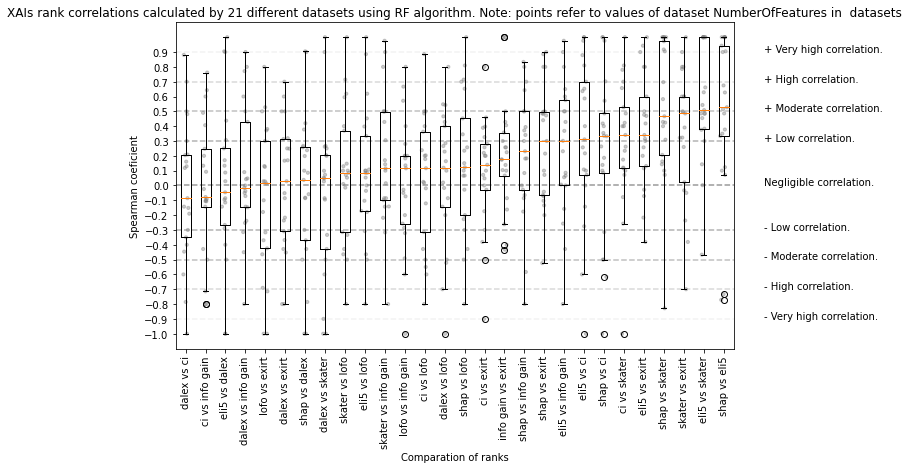

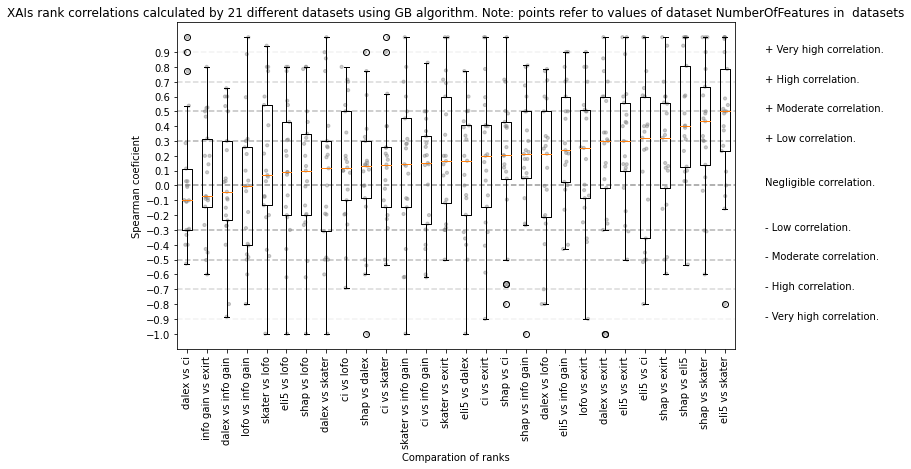

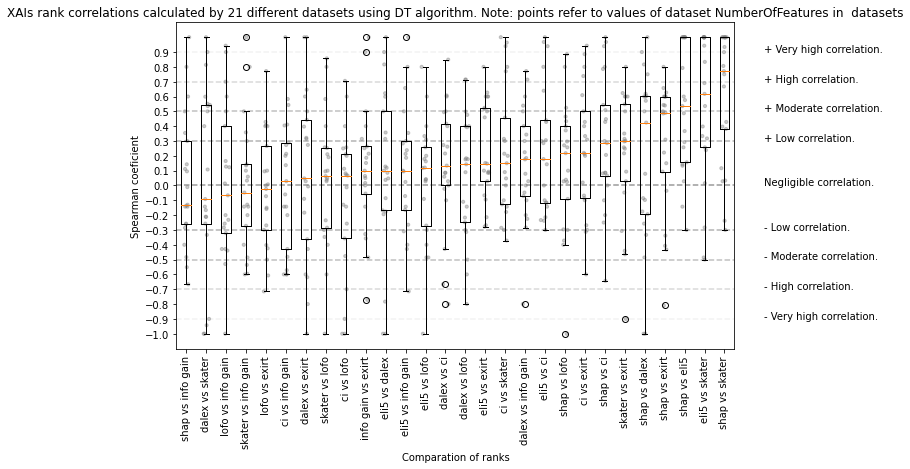

In [ ]:
plot_resume(dfs_ret_0, df_dataset_properties_cluster_0, models_name_0)

## Execute benchmark to cluster 1

In [36]:
cluster = 1

df_prop_tmp = df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster))
list_dataset = list(df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster)).index)
dfs_ret_1, df_dataset_properties_cluster_1, models_name_1 = main_benchmark(list_dataset, df_prop_tmp)


Output hidden; open in https://colab.research.google.com to view.

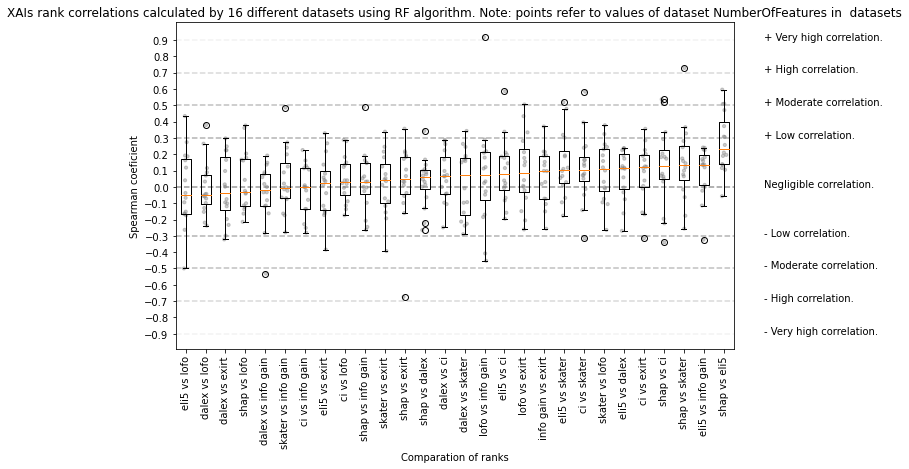

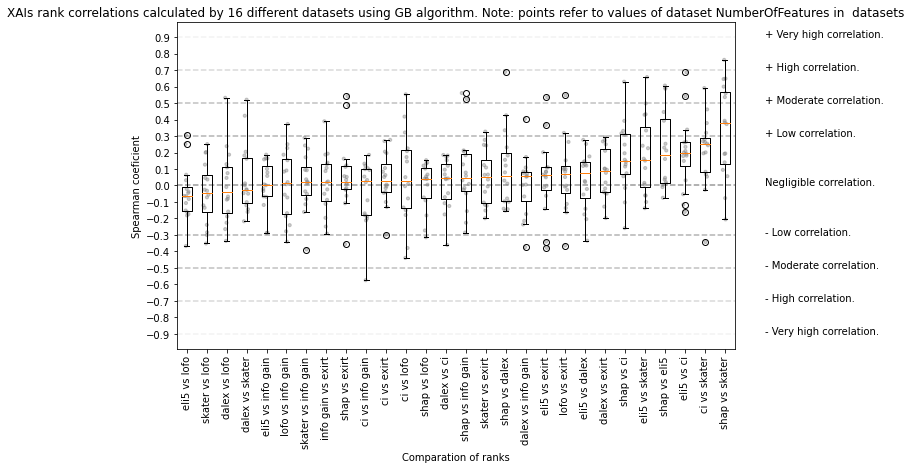

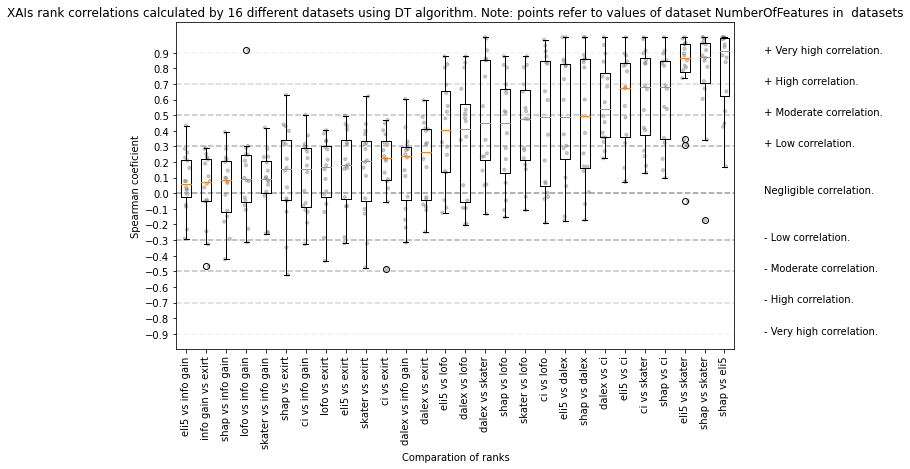

In [37]:
plot_resume(dfs_ret_1, df_dataset_properties_cluster_1, models_name_1)

## Execute benchmark to cluster 2

## Execution of benchmark to: 
['kr-vs-kp', 'PhishingWebsites', 'SPECT']
<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: kr-vs-kp
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:19:28
Licence.......: Public
Download URL..: https://old.openml.org/data/v1/download/3/kr-vs-kp.arff
OpenML URL....: https://www.openml.org/d/3
# of features.: 37
# of instances: 3196>
    bkblk  bknwy  bkon8  bkona  bkspr  bkxbq  bkxcr  bkxwp  blxwp  bxqsq  ...  \
0     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
1     1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0  ...   
2     1.0    1.0    1.0    1.0    0.0    1.0    0.0    1.0    1.0    1.0  ...   
3     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0  ...   
4     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
95    1.0    1.0    1.0   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       n_estimators=200)

   Accuracy  Precision    Recall
0  0.973931   0.966667  0.984032

## confusion matrix  rf  ##
  Correct True:  0.962882096069869  Uncorrect True:  0.03711790393013101
Uncorrect True:  0.015968063872255488    Correct True:  0.9840319361277445
Fitting 3 folds for each of 64 candidates, totalling 192 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                           min_samples_leaf=10)

   Accuracy  Precision    Recall
0  0.997914   0.998004  0.998004

## confusion matrix  gb  ##
  Correct True:  0.9978165938864629  Uncorrect True:  0.002183406113537118
Uncorrect True:  0.001996007984031936    Correct True:  0.998003992015968
Fitting 3 folds for each of 240 candidates, totalling 720 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DecisionTreeClassifier(max_depth=12, max_features='sqrt', min_samples_split=20)

   Accuracy  Precision    Recall
0  0.937435   0.954639  0.924152

## confusion matrix  dt  ##
  Correct True:  0.9519650655021834  Uncorrect True:  0.048034934497816595
Uncorrect True:  0.07584830339321358    Correct True:  0.9241516966067864


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

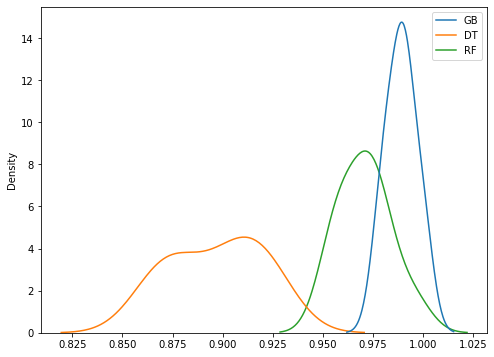

Friedman Test
FriedmanchisquareResult(statistic=20.0, pvalue=4.539992976248486e-05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

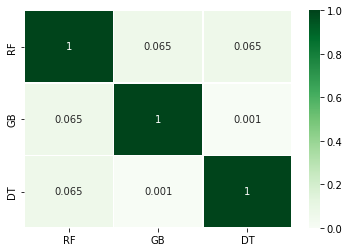

Shap explaning...
Eli5 explaning...
Dalex explaning...
CI explaning...
Skater explaning...
Lofo explaning...


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

eXirt explaning...
Calculando os parametros do IRT para o dataset:  /content/tabela_base_para_executar_irt.csv
R[write to console]: Warning message:

R[write to console]: In tpm(read.csv(file = "tmp_irt_teste.csv"), IRT.param = TRUE) :
R[write to console]: 
 
R[write to console]:  Hessian matrix at convergence contains infinite or missing values; unstable solution.


As frequencias dos parametros de item foram salvas \o/

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2044: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2045: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)
Todos os valores de Theta foram salvos \o/
No handles with labels found to put in legend.

Os scores dos classificadores para todos os datasets foram salvos \o/

Calculando os parametros do IRT para o dataset:  /content/tabela_base_para_executar_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

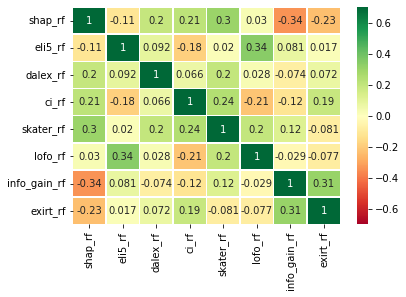

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

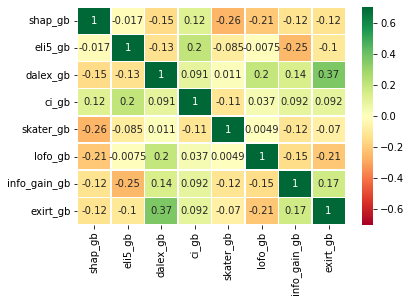

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

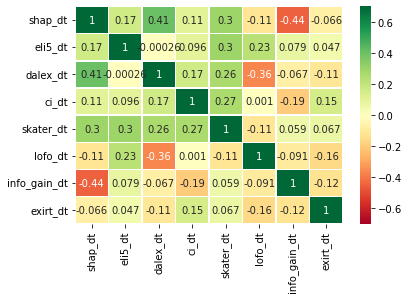

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: PhishingWebsites
Version.......: 1
Format........: ARFF
Upload Date...: 2016-02-16 15:30:33
Licence.......: Public
Download URL..: https://old.openml.org/data/v1/download/1798106/PhishingWebsites.arff
OpenML URL....: https://www.openml.org/d/4534
# of features.: 31
# of instances: 11055>
    having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 0.0    0.206799                 1.0               1.0   
1                 1.0    0.206799                 1.0               1.0   
2                 1.0    0.000000                 1.0               1.0   
3                 1.0    0.000000                 1.0               1.0   
4                 1.0    0.000000                 0.0               1.0   
..                ...         ...                 ...               ...   
95                1.0    1.000000                 1.0               1.0   
96                1.0    1.000000       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       n_estimators=200)

   Accuracy  Precision    Recall
0  0.953271   0.956803  0.959394

## confusion matrix  rf  ##
  Correct True:  0.9455782312925171  Uncorrect True:  0.05442176870748299
Uncorrect True:  0.040606388738494856    Correct True:  0.9593936112615051
Fitting 3 folds for each of 64 candidates, totalling 192 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(loss='exponential', max_depth=10,
                           max_features='sqrt', min_samples_leaf=10,
                           n_estimators=200)

   Accuracy  Precision   Recall
0  0.971058   0.970952  0.97726

## confusion matrix  gb  ##
  Correct True:  0.963265306122449  Uncorrect True:  0.036734693877551024
Uncorrect True:  0.02273957769355712    Correct True:  0.9772604223064428
Fitting 3 folds for each of 240 candidates, totalling 720 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DecisionTreeClassifier(max_depth=12, max_features='sqrt', min_samples_split=20)

   Accuracy  Precision    Recall
0  0.915586   0.933112  0.913914

## confusion matrix  dt  ##
  Correct True:  0.917687074829932  Uncorrect True:  0.08231292517006802
Uncorrect True:  0.08608554412560909    Correct True:  0.9139144558743909


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

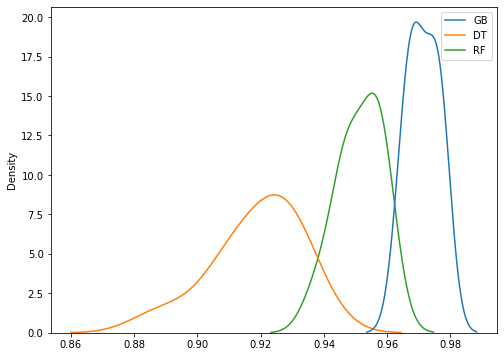

Friedman Test
FriedmanchisquareResult(statistic=20.0, pvalue=4.539992976248486e-05)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

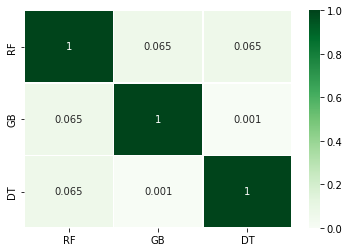

Shap explaning...
Eli5 explaning...
Dalex explaning...
CI explaning...
Skater explaning...
Lofo explaning...


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

eXirt explaning...
Calculando os parametros do IRT para o dataset:  /content/tabela_base_para_executar_irt.csv
R[write to console]: Warning message:

R[write to console]: In tpm(read.csv(file = "tmp_irt_teste.csv"), IRT.param = TRUE) :
R[write to console]: 
 
R[write to console]:  Hessian matrix at convergence contains infinite or missing values; unstable solution.


As frequencias dos parametros de item foram salvas \o/

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2044: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2045: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2046: RuntimeWarning: invalid value encountered in double_scalars
  p = (xf - fulc) * q - (xf - nfc) * r
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2047: Run

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

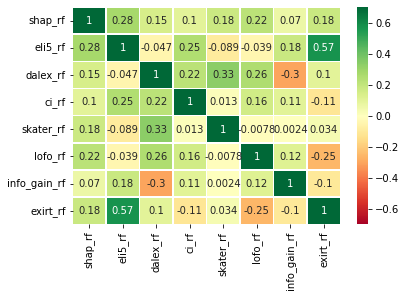

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

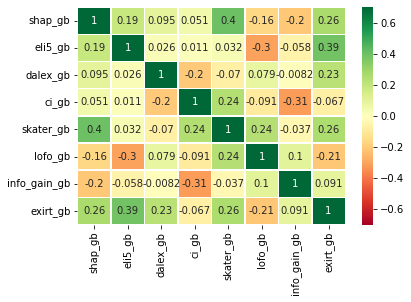

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

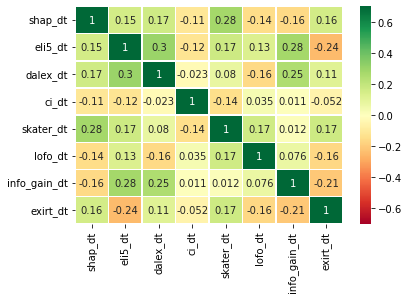

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<bound method OpenMLDataset.get_data of OpenML Dataset
Name..........: SPECT
Version.......: 1
Format........: ARFF
Upload Date...: 2014-08-26 17:57:57
Licence.......: Public
Download URL..: https://old.openml.org/data/v1/download/52239/SPECT.arff
OpenML URL....: https://www.openml.org/d/336
# of features.: 23
# of instances: 267>
     F1   F2   F3   F4   F5   F6   F7   F8   F9  F10  ...  F13  F14  F15  F16  \
0   1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  1.0   
1   1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  1.0   
2   0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  ...  0.0  1.0  1.0  1.0   
3   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
4   1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...  0.0  1.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  ...  0.0  1.0  1.0  1.0   
96  0.0  0.0  1.0  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier(max_depth=1, max_features='log2', min_samples_leaf=10)

   Accuracy  Precision  Recall
0  0.790123   0.790123     1.0

## confusion matrix  rf  ##
  Correct True:  0.0  Uncorrect True:  1.0
Uncorrect True:  0.0    Correct True:  1.0
Fitting 3 folds for each of 64 candidates, totalling 192 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GradientBoostingClassifier(loss='exponential', max_depth=1, max_features='sqrt')

   Accuracy  Precision    Recall
0  0.814815   0.835616  0.953125

## confusion matrix  gb  ##
  Correct True:  0.29411764705882354  Uncorrect True:  0.7058823529411765
Uncorrect True:  0.046875    Correct True:  0.953125
Fitting 3 folds for each of 240 candidates, totalling 720 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DecisionTreeClassifier(max_depth=12, max_features='log2', min_samples_split=15,
                       splitter='random')

   Accuracy  Precision   Recall
0  0.753086   0.805556  0.90625

## confusion matrix  dt  ##
  Correct True:  0.17647058823529413  Uncorrect True:  0.8235294117647058
Uncorrect True:  0.09375    Correct True:  0.90625


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

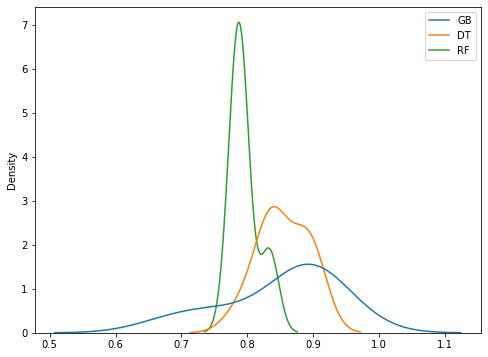

Friedman Test
FriedmanchisquareResult(statistic=7.032258064516133, pvalue=0.029714235677790368)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

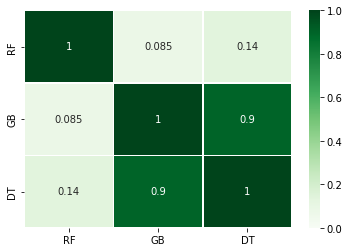

Shap explaning...
Eli5 explaning...
Dalex explaning...
CI explaning...
Skater explaning...
Lofo explaning...


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

eXirt explaning...
Calculando os parametros do IRT para o dataset:  /content/tabela_base_para_executar_irt.csv
R[write to console]: Warning message:

R[write to console]: In tpm(read.csv(file = "tmp_irt_teste.csv"), IRT.param = TRUE) :
R[write to console]: 
 
R[write to console]:  Hessian matrix at convergence contains infinite or missing values; unstable solution.


As frequencias dos parametros de item foram salvas \o/

Todos os valores de Theta foram salvos \o/
No handles with labels found to put in legend.

Os scores dos classificadores para todos os datasets foram salvos \o/

Calculando os parametros do IRT para o dataset:  /content/tabela_base_para_executar_irt.csv
R[write to console]: Warning message:

R[write to console]: In tpm(read.csv(file = "tmp_irt_teste.csv"), IRT.param = TRUE) :
R[write to console]: 
 
R[write to console]:  Hessian matrix at convergence contains infinite or missing values; unstable solution.


As frequencias dos parametros de item foram salvas \o/

Todos

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

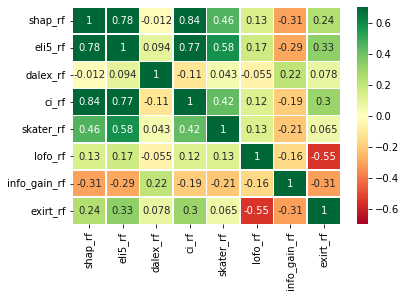

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

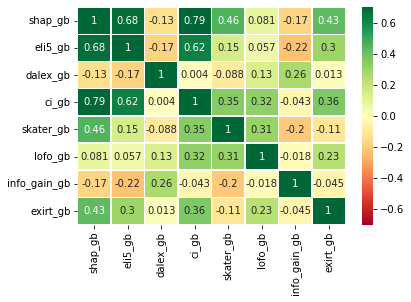

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

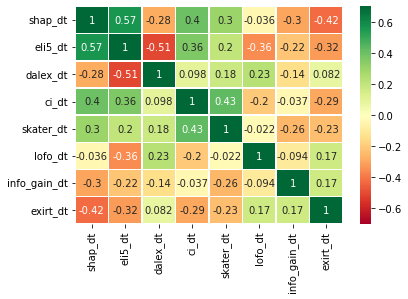

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TypeError: ignored

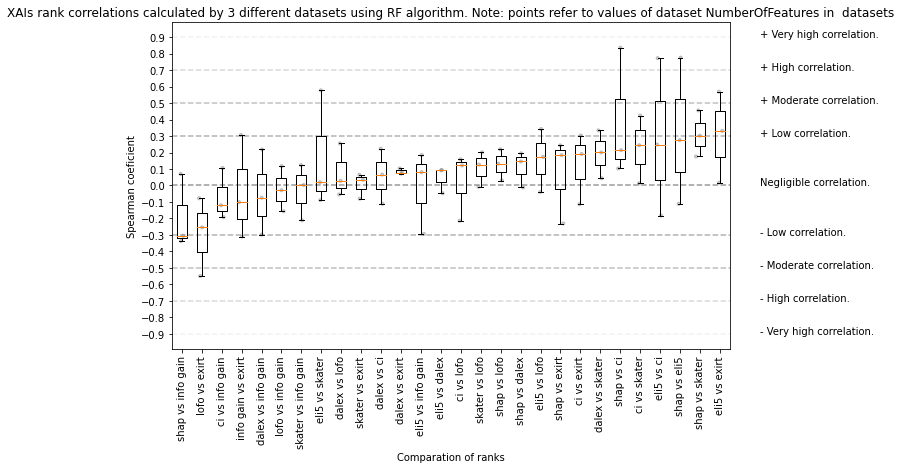

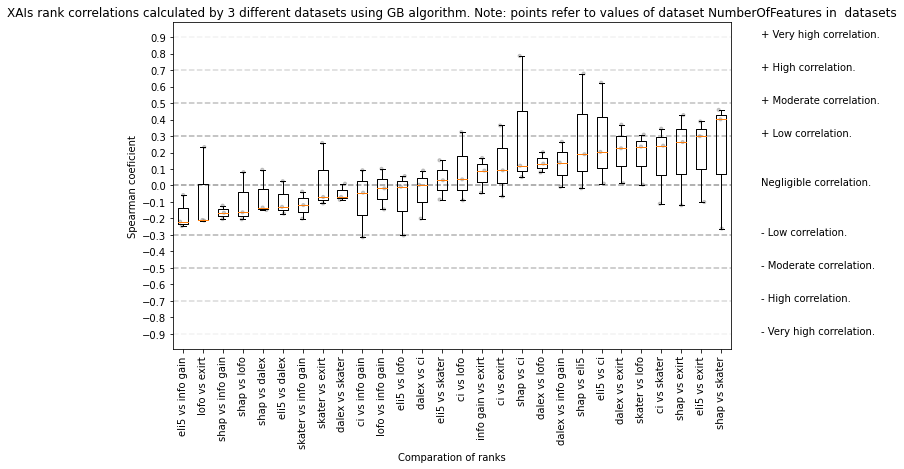

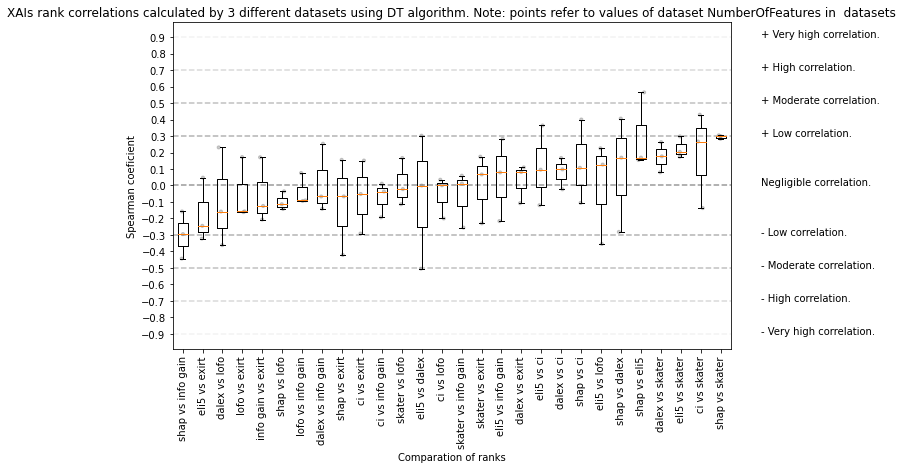

In [ ]:
cluster = 2

df_prop_tmp = df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster))
list_dataset = list(df_dataset_properties.query(k_cluster_selected + ' == '+str(cluster)).index)
dfs_ret_2, df_dataset_properties_cluster_2, models_name_2 = main_benchmark(list_dataset, df_prop_tmp)

In [ ]:
plot_resume(dfs_ret_2, df_dataset_properties_cluster_2, models_name_2)

NameError: ignored

## Camada de Visualização


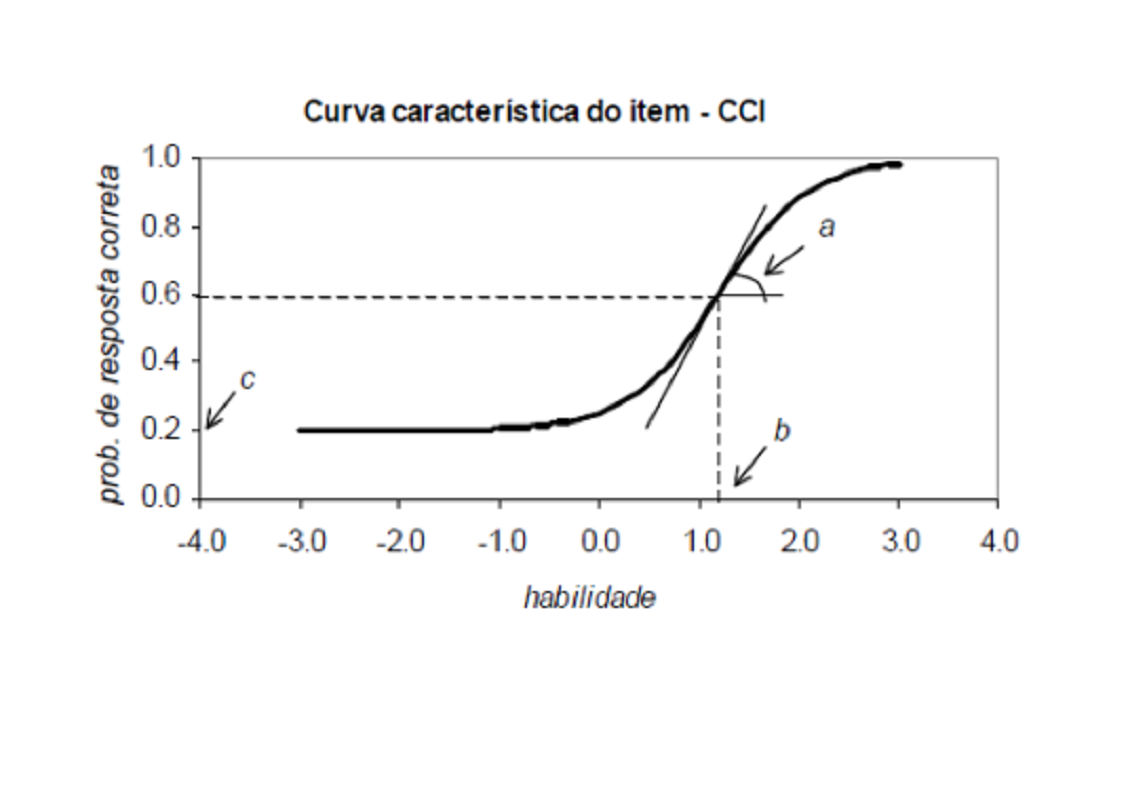

In [ ]:
plt.figure(figsize=(10,10))
for i,_ in enumerate(rirt.index):
  x_axis = linspace(-10, 10, 100)
    
  #Modelo Logistico de 3 parâmetros 
  a = rirt.iloc[i]['Discriminacao']
  b = rirt.iloc[i]['Dificuldade']
  c = rirt.iloc[i]['Adivinhacao']
  
  y_axis = c + (1 - c) * (1/(1+math.e**(-a*(x_axis - b))))

  plt.plot(x_axis, y_axis)

plt.xlabel('Habilidade',fontsize=15)
plt.ylabel('Prob. resposta correta',fontsize=15)
plt.title('CCI - 3', fontsize=15)

In [ ]:
plt.figure(figsize=(10,10))

for i,_ in enumerate(rirt.index):
  x_axis = linspace(-15, 15, 100)
    
  #Modelo Hash
  b = rirt.iloc[i]['Dificuldade']

  y_axis = 1 / (1+math.e**(-(x_axis - b)))

  plt.plot(x_axis, y_axis)

plt.xlabel('Dificuldade',fontsize=15)
plt.ylabel('Prob. resposta correta',fontsize=15)
plt.title('Modelo Hash', fontsize=15)